# Study beam impact point as a function of beam position


In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import batoid
from scipy import stats

from ghosts import tools
from ghosts import plotter
from ghosts import simulator
from ghosts import tweak_optics
from ghosts import beam
from ghosts import geom
from ghosts import reflectivity

from ghosts.analysis import compute_ghost_separations, reduce_ghosts
from ghosts.analysis import match_ghosts, compute_reduced_distance, compute_2d_reduced_distance, find_nearest_ghost
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_0, BEAM_CONFIG_1, BEAM_CONFIG_3, BEAM_CONFIG_4, FAST_BEAM_CONFIG_1, BASE_BEAM_SET
from ghosts.geom_configs import GEOM_CONFIG_0, GEOM_CONFIG_1, GEOM_CONFIG_2

from ghosts.camera import build_camera, show_camera

plt.rcParams['font.size']=12

In [3]:
# Some numbers from the constants module for reference
from ghosts.constants import *
print(f'LSST Camera has {LSST_CAMERA_PIXEL_DENSITY_MM2:.0f} pixels per mm^2')
print(f'Camera readout noise {LSST_CAMERA_READOUT_NOISE:d} electrons')
print(f'Camera dark current {LSST_CAMERA_DARK_CURRENT:d} electrons')
print(f'Camera noise {LSST_CAMERA_NOISE:d} electrons')
print(f'Camera pixel size {LSST_CAMERA_PIXEL_SIZE:.6f} m')

LSST Camera has 9000 pixels per mm^2
Camera readout noise 5 electrons
Camera dark current 2 electrons
Camera noise 10 electrons
Camera pixel size 0.000010 m


# Straight forward computation of the expected number of photons per pixel expected in the main spot without any filter

In [4]:
# A few numbers, sepcific to 600 nm
beam_power_600nm = 13  # 13 Watt for the full spot according to measurements done in Grenoble
ccd_reflectivity_600nm = 0.141338
ccd_qe_600nm = 0.843274
lens_reflectivity_600nm = 0.004  # 0.4% code by Julien Bolmont
filter_reflectivity_600nm = 0.038  # r band filter documentation stated transmission is 96.2%

In [5]:
# Straight forward calculation for the main spot for 100 nW
n_phot = beam.get_n_phot_for_power_nw_wl_nm(100, 600)
print(f"N photons from 100 nW at 600 nm {n_phot:e}")
n_phot_to_pixel = n_phot * (1-lens_reflectivity_600nm)**6 \
                         * (1-ccd_reflectivity_600nm) \
                         * ccd_qe_600nm * 0.9  # lens transmission, detector transmission, QE and pixels fill
print(f"N photons to pixel {n_phot_to_pixel:e}")
spot_size = (1.228)**2*math.pi
print(f"Spot size in mm2 {spot_size:.1f}")
pixel_size = 10e-3**2
print(f"Pixel size in mm2 {pixel_size:.6f}")
n_pixel_spot = spot_size/pixel_size
print(f"N pixels per spot {n_pixel_spot:e}")
n_phot_per_pixel = n_phot_to_pixel/n_pixel_spot
print(f"N photons per pixel {n_phot_per_pixel:e} for 100 nW at 600 nm")

N photons from 100 nW at 600 nm 3.020470e+11
N photons to pixel 1.921605e+11
Spot size in mm2 4.7
Pixel size in mm2 0.000100
N pixels per spot 4.737471e+04
N photons per pixel 4.056182e+06 for 100 nW at 600 nm


## conclusions
- For a 100 nW beam of 2.5 mm of diameter at 600 nm, the main spot is expected to cover 47000 pixels, with around 4 millions of photons in each pixel for a 1 s exposure.
- The full well being around 100k p.e., the main spot will be highly saturated.
- To get down to a reasonable value, we need a factor of a 100 on the flux or on the exposure: that can ben achieved by using the CCOB high speed shutter with an exposure of 10 ms.

# Now run the full CCOB simulation and analysis with the Filter

In [6]:
# adjust beam config
BEAM_CONFIG_600 = copy.deepcopy(BEAM_CONFIG_4)
BEAM_CONFIG_600['id'] = 600
BEAM_CONFIG_600['wl'] = 600e-9
BEAM_CONFIG_600['n_photons'] = 1000


Direct path is number 27
  central impact point is (-0.080032, 0.164217)
  transmission is 0.7758

Maximum expected flux is 0.7758
Maximum bin content is 535.2247


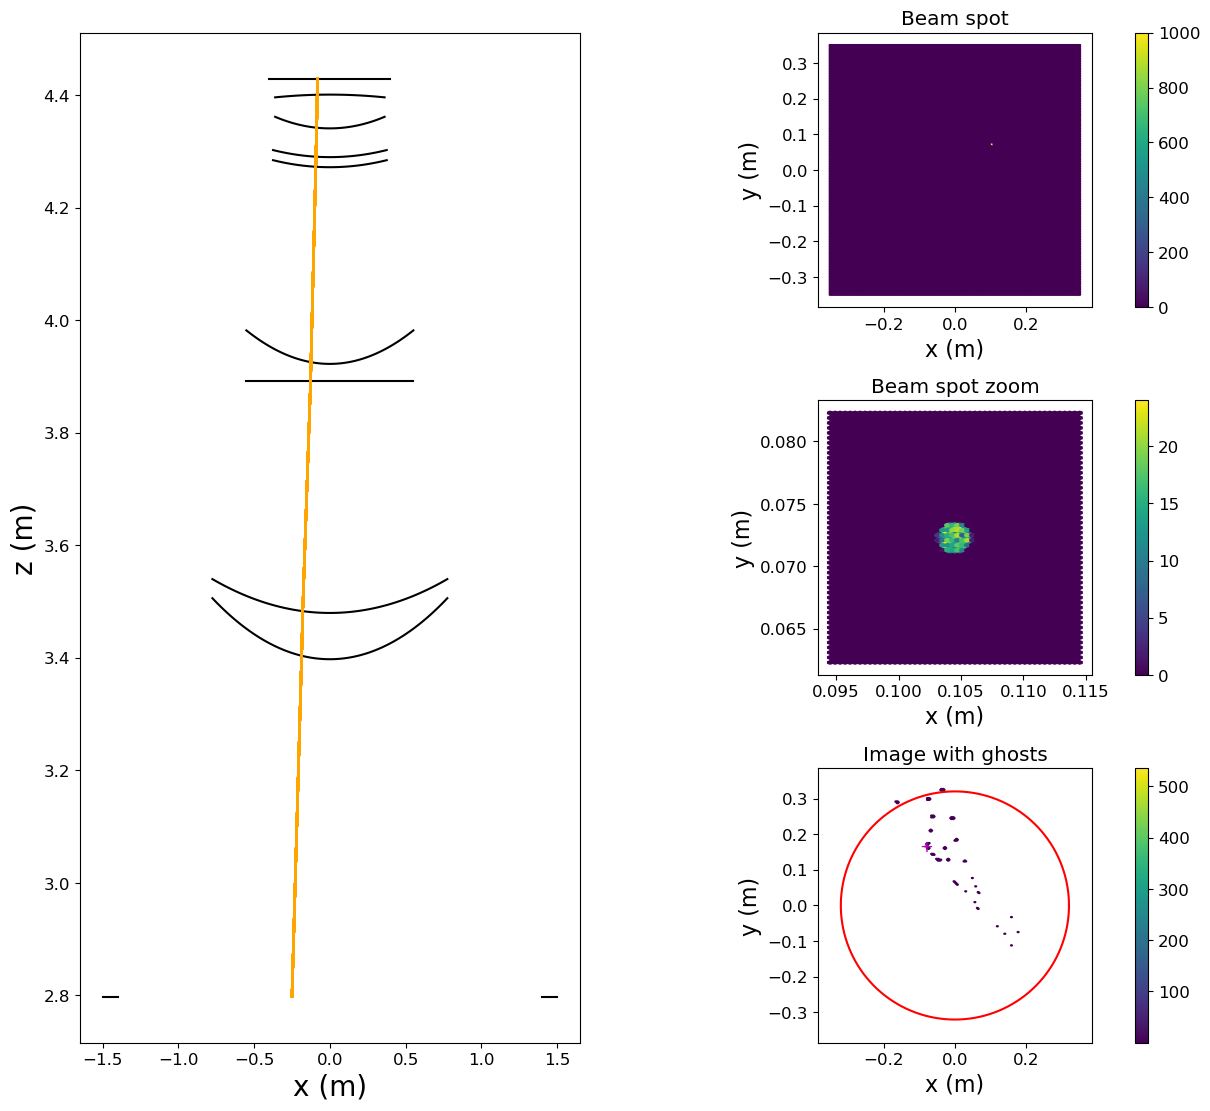

<AxesSubplot:title={'center':'Ghosts representation'}, xlabel='x (m)', ylabel='y (m)'>

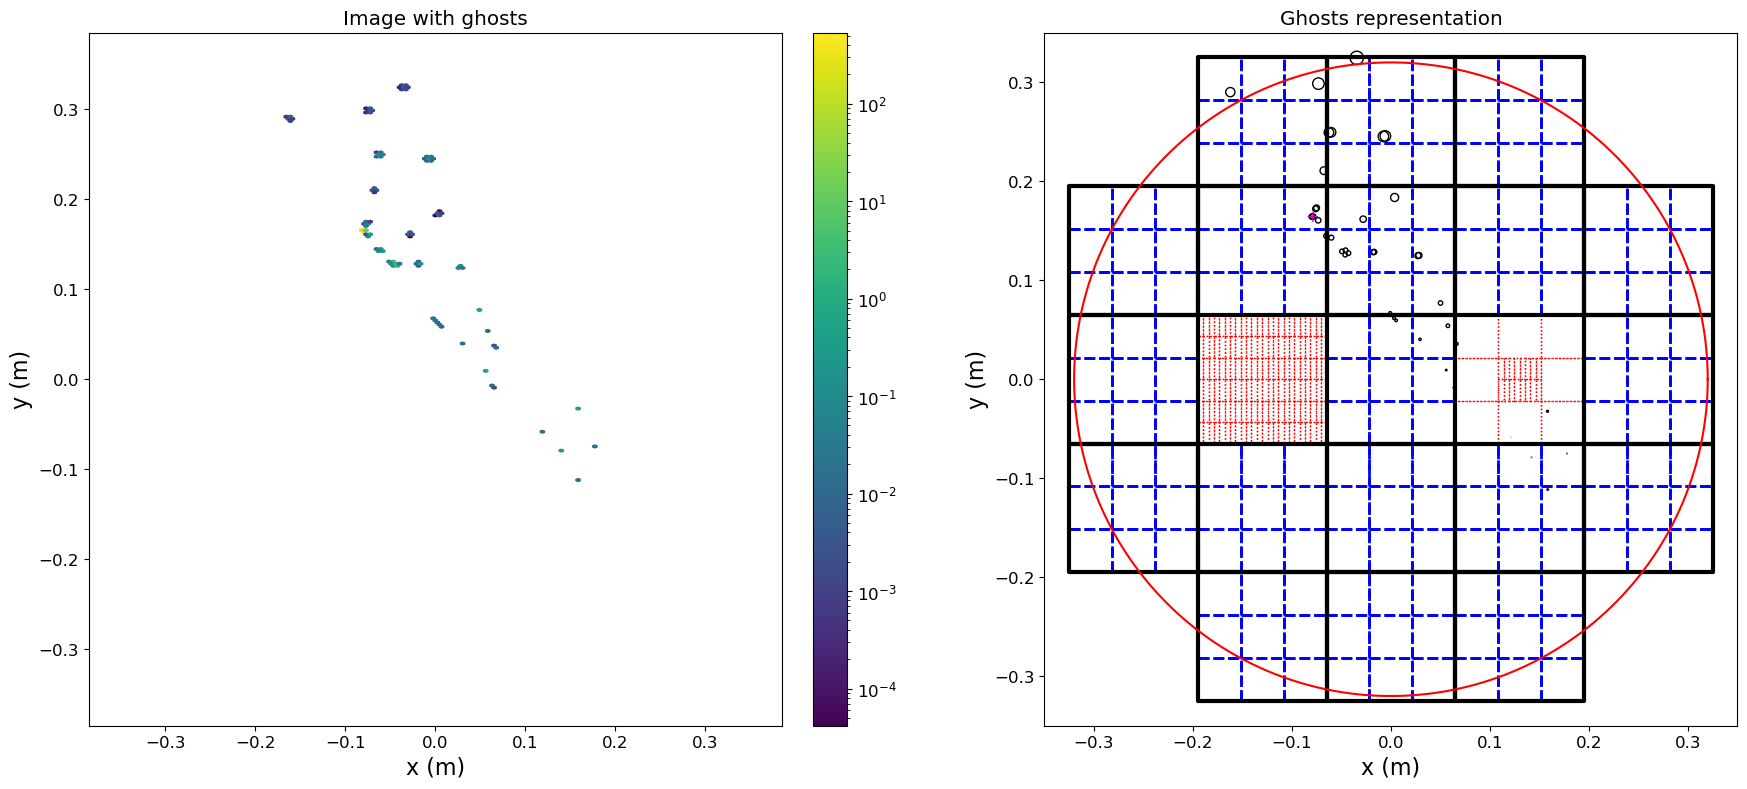

In [7]:
# Second CCOB like geometry, i.e. lenses + filters
#telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r.yaml")
telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r_with_filter.yaml")

# Make refractive interfaces partially reflective
# Call on current telescope, smart coating is [lens, filter, camera]
tweak_optics.make_optics_reflective(telescope, coating='smart',
                                    r_frac=[lens_reflectivity_600nm, filter_reflectivity_600nm, ccd_reflectivity_600nm])

# Run simulation with standard beam config
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=BEAM_CONFIG_600)
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)

# camera and ghosts visualization
spots_data, _spots = reduce_ghosts(r_forward)
spots_data_frame = make_data_frame(spots_data)
_fig, ax = plotter.plot_full_camera_and_spots(r_forward, spots_data_frame, log_scale=True)
camera = build_camera()
show_camera(ax[1], camera)


Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


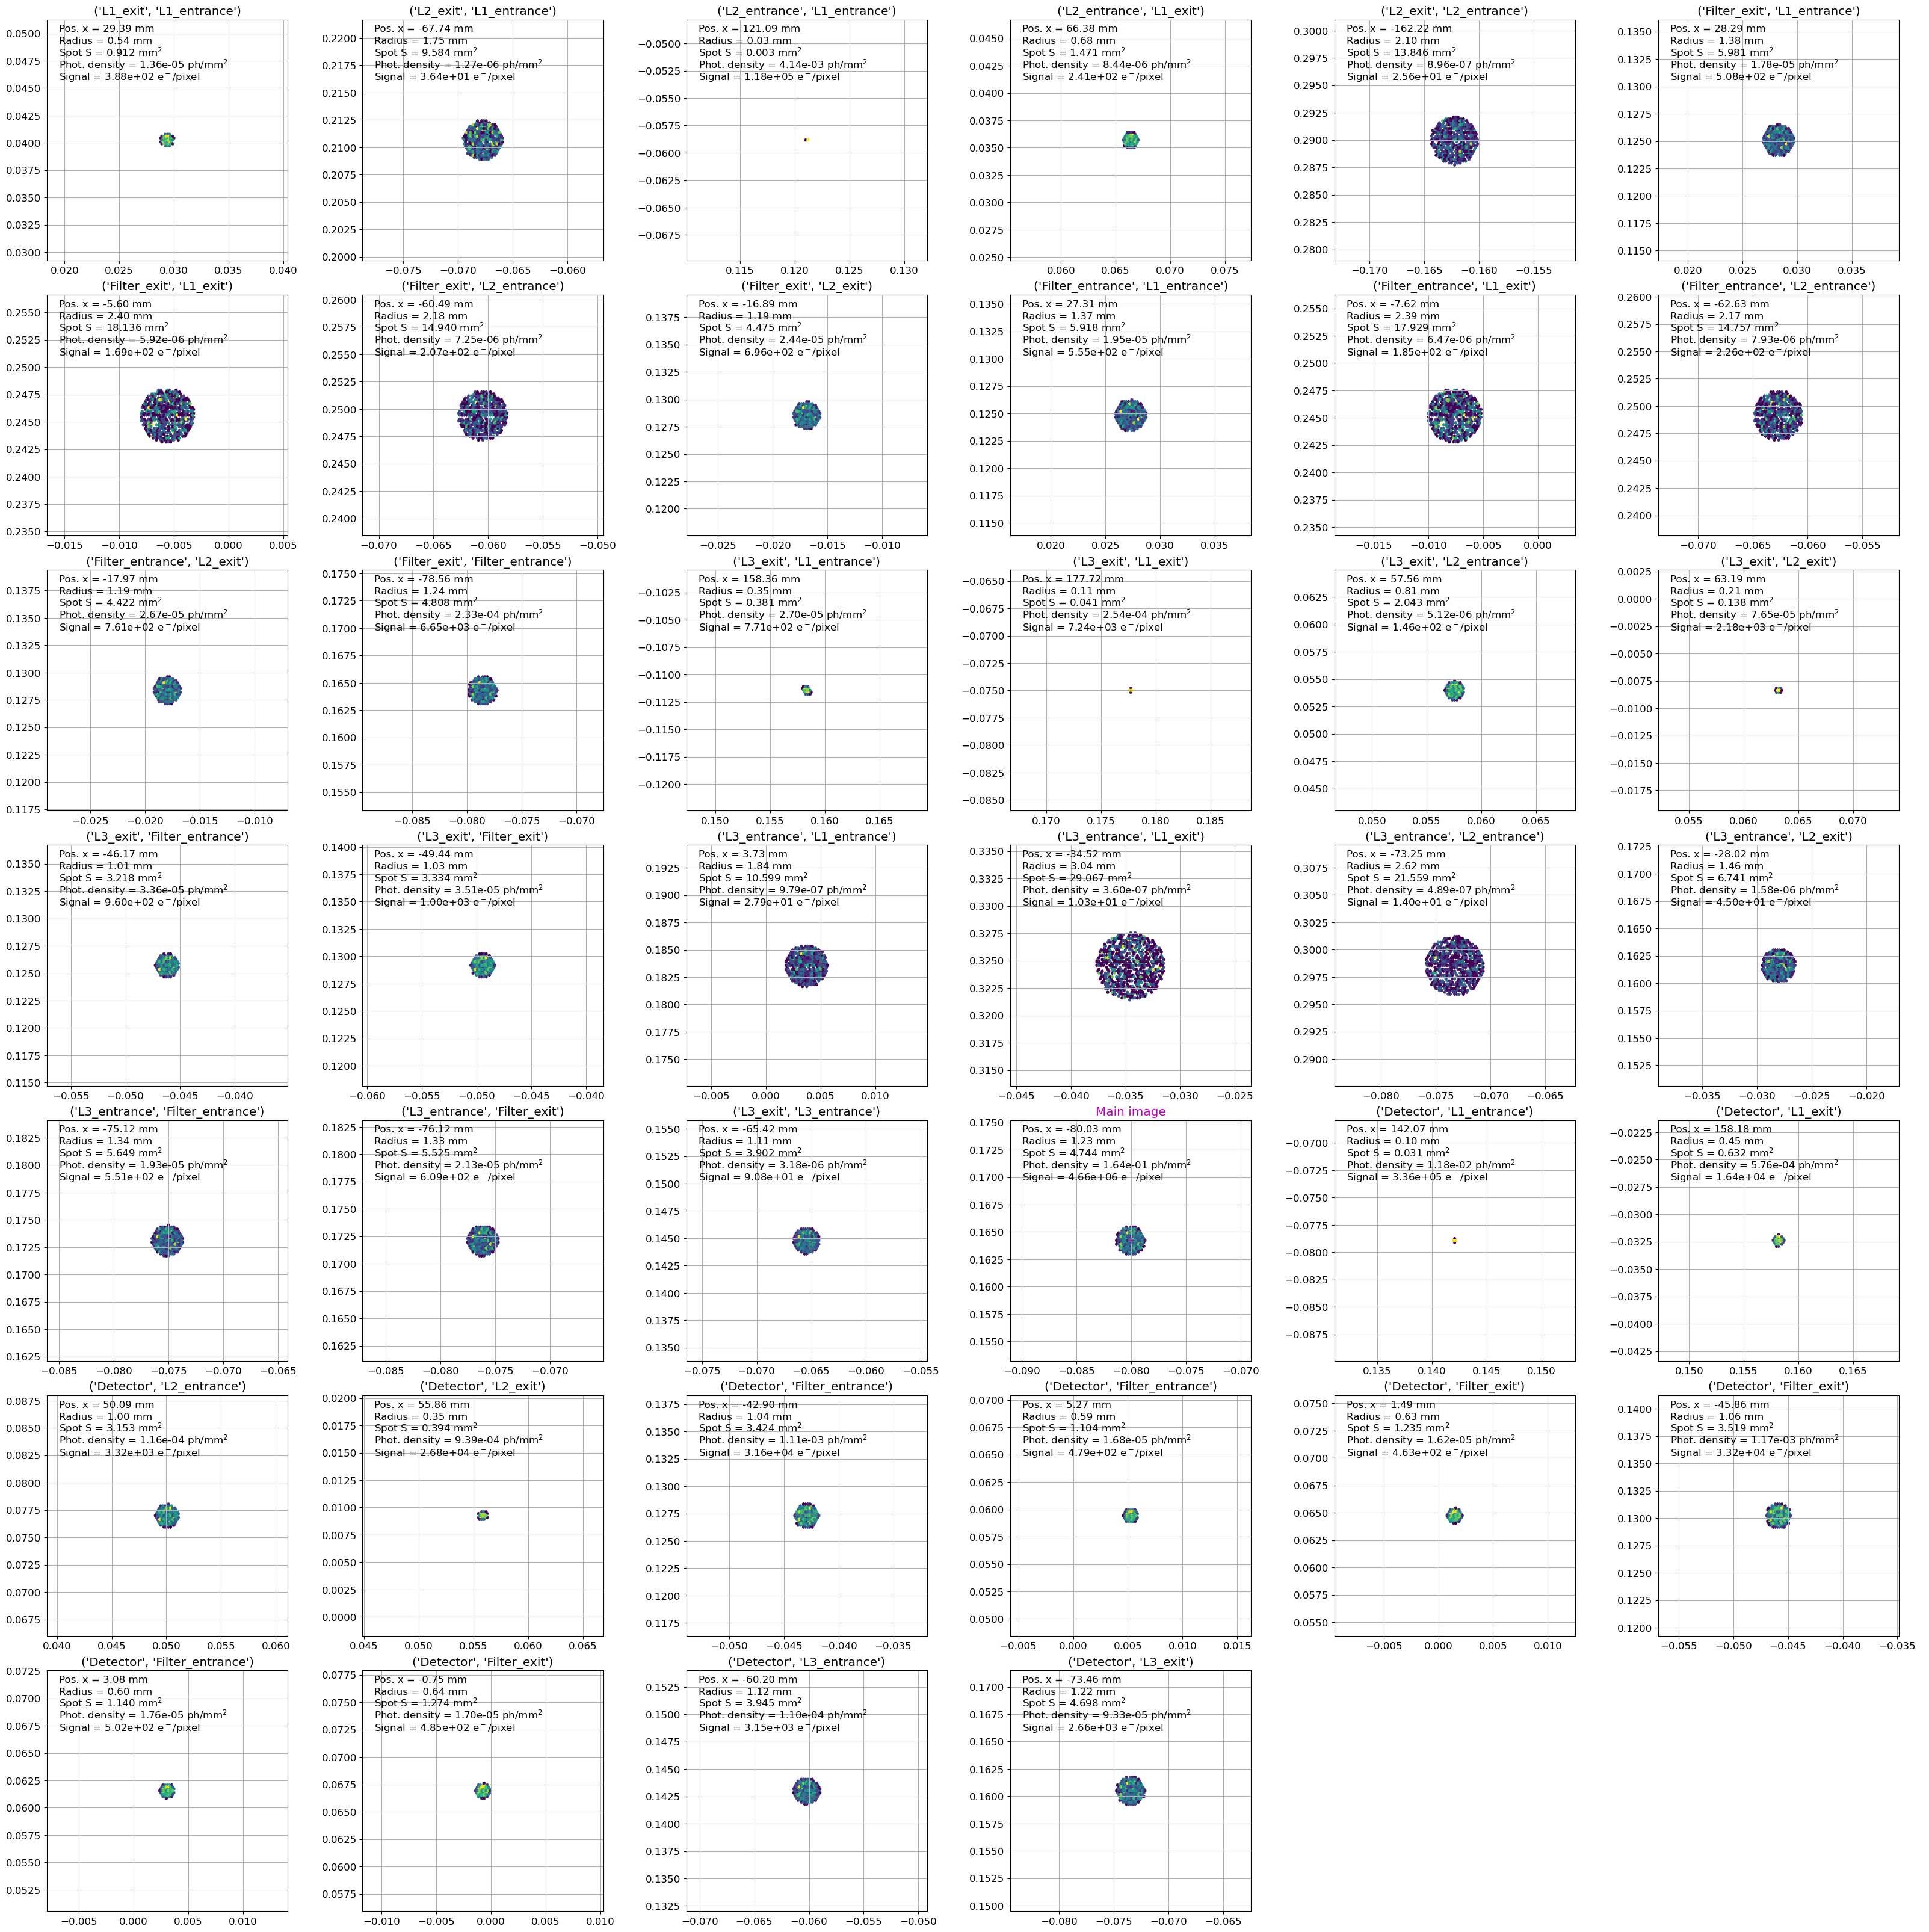

In [8]:
# make figure and fill with plots
spots_data = plotter.plot_ghosts_map(r_forward)

In [9]:
spots_data_frame.sort_values('pixel_signal', axis=0)

beam_id  geom_id  index                            name     pos_x  \
21        0        0     21          (L3_entrance, L1_exit) -0.034520   
22        0        0     22      (L3_entrance, L2_entrance) -0.073251   
4         0        0      4          (L2_exit, L2_entrance) -0.162221   
20        0        0     20      (L3_entrance, L1_entrance)  0.003725   
1         0        0      1          (L2_exit, L1_entrance) -0.067735   
23        0        0     23          (L3_entrance, L2_exit) -0.028018   
26        0        0     26          (L3_exit, L3_entrance) -0.065419   
16        0        0     16          (L3_exit, L2_entrance)  0.057557   
6         0        0      6          (Filter_exit, L1_exit) -0.005597   
10        0        0     10      (Filter_entrance, L1_exit) -0.007619   
7         0        0      7      (Filter_exit, L2_entrance) -0.060489   
11        0        0     11  (Filter_entrance, L2_entrance) -0.062626   
3         0        0      3          (L2_entrance, L1_exit)  0.066379   
0         0        0      0          (L1_exit, L1_entrance)  0.029395   
34        0        0     34         (Detector, Filter_exit)  0.001492   
33        0        0     33     (Detector, Filter_entrance)  0.005266   
37        0        0     37         (Detector, Filter_exit) -0.000751   
36        0        0     36     (Detector, Filter_entrance)  0.003079   
5         0        0      5      (Filter_exit, L1_entrance)  0.028287   
24        0        0     24  (L3_entrance, Filter_entrance) -0.075116   
9         0        0      9  (Filter_entrance, L1_entrance)  0.027311   
25        0        0     25      (L3_entrance, Filter_exit) -0.076124   
8         0        0      8          (Filter_exit, L2_exit) -0.016894   
12        0        0     12      (Filter_entrance, L2_exit) -0.017972   
14        0        0     14          (L3_exit, L1_entrance)  0.158360   
18        0        0     18      (L3_exit, Filter_entrance) -0.046175   
19        0        0     19          (L3_exit, Filter_exit) -0.049437   
17        0        0     17              (L3_exit, L2_exit)  0.063195   
39        0        0     39             (Detector, L3_exit) -0.073464   
38        0        0     38         (Detector, L3_entrance) -0.060198   
30        0        0     30         (Detector, L2_entrance)  0.050090   
13        0        0     13  (Filter_exit, Filter_entrance) -0.078564   
15        0        0     15              (L3_exit, L1_exit)  0.177719   
29        0        0     29             (Detector, L1_exit)  0.158180   
31        0        0     31             (Detector, L2_exit)  0.055857   
32        0        0     32     (Detector, Filter_entrance) -0.042903   
35        0        0     35         (Detector, Filter_exit) -0.045855   
2         0        0      2      (L2_entrance, L1_entrance)  0.121091   
28        0        0     28         (Detector, L1_entrance)  0.142072   
27        0        0     27                    (main, main) -0.080032   

       std_x     pos_y     std_y   width_x   width_y    radius  radius_err  \
21  0.001539  0.324570  0.001539  0.006053  0.006114  0.003042    0.000030   
22  0.001311  0.298567  0.001311  0.005157  0.005321  0.002620    0.000082   
4   0.001048  0.290000  0.001048  0.004119  0.004278  0.002099    0.000080   
20  0.000929  0.183574  0.000929  0.003653  0.003694  0.001837    0.000020   
1   0.000884  0.210669  0.000884  0.003476  0.003510  0.001747    0.000017   
23  0.000740  0.161630  0.000740  0.002912  0.002948  0.001465    0.000018   
26  0.000563  0.144791  0.000563  0.002213  0.002244  0.001114    0.000015   
16  0.000409  0.053982  0.000409  0.001608  0.001618  0.000806    0.000005   
6   0.001219  0.245618  0.001219  0.004792  0.004819  0.002403    0.000013   
10  0.001212  0.245241  0.001212  0.004765  0.004791  0.002389    0.000013   
7   0.001098  0.249446  0.001098  0.004320  0.004403  0.002181    0.000042   
11  0.001092  0.249171  0.001092  0.004293  0.004376  0.002167    0.000041

In [10]:
# scaling flux
main_flux = 4.983946e+06
target_flux = main_flux/50.
print(f"Main flux / 50 = {target_flux:e}, fair enough for 10000 full well")

Main flux / 50 = 9.967892e+04, fair enough for 10000 full well


In [11]:
# compute pixel signal log10
spots_data_frame["pixel_signal_log"] = np.log10(spots_data_frame["pixel_signal"])

In [12]:
def plot_spots_intensity(spots_data_frame):
    plt.rcParams["figure.figsize"] = [9, 6]
    spots_data_frame.plot.bar("name", "pixel_signal_log")
    plt.xlabel("Ghost")
    plt.ylabel("log10(pixel_signal)")
    plt.axhline(5, color="red")
    plt.axhline(1, color="black")
    plt.axhline(1.5, color="cyan")
    plt.title("Photons per pixel in each ghost spot\nfor a 100 nW beam of diameter 2.5 mm\nat 600 nm for a 1 s exposure")

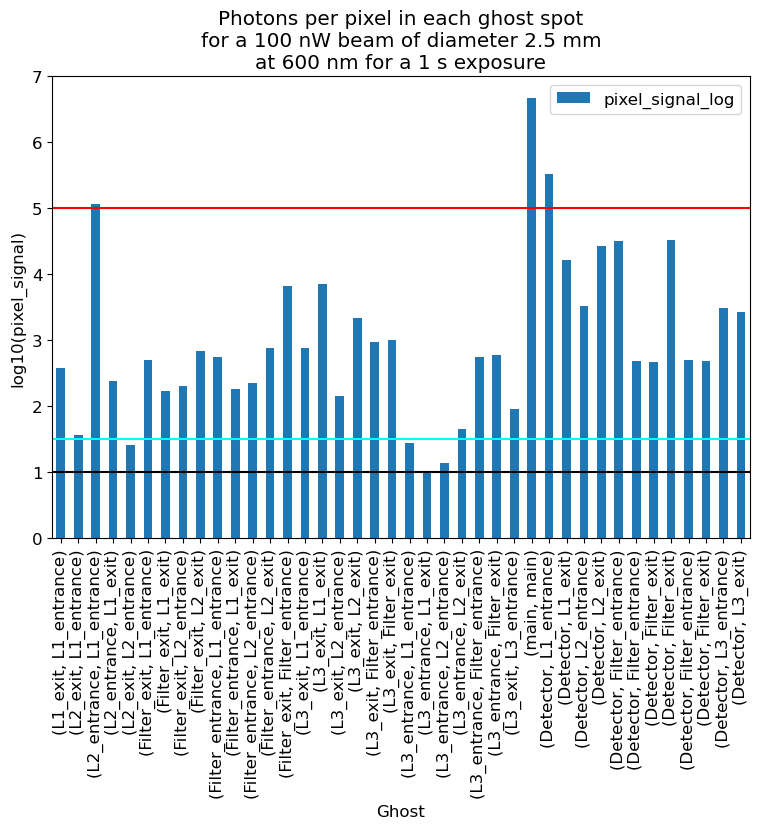

In [13]:
plot_spots_intensity(spots_data_frame)

## Conclusions
- For a 100 nW beam of diameter 2.5 mm at 600 nm, and a 1 s exposure, the main spot covers 42k pixels with 4.7 millions photons per pixel.
  - As a reference, the CCOB beam power ranges from 10 nW to 100 nW depending upon the wavelength.
- The deemest ghost spot has a size of 6 mm in diameter and covers 260k pixels with just about 10 photons per pixel.
- The brightest ghost spot has a size of 0.042 mm in diameter and covers only 12 pixels with 260k photons per pixel.
- 2 ghosts spots are indeed saturated in that configuration: (Detector, L1_entrance) at almost 500k p.e./px and (L2_entrance, L1_entrance) at 260k p.e./px.
- 3 ghosts spots have a low signal: (L3_entrance, L1_exit) at 10 p.e./px, (L3_entrance, L2_entrance) and (L2_exit, L1_exit) at 15 p.e./px.
- Given this dynamic range, by dividing the exposure time by a factor of 5, i.e. 20 ms with the high speed shutter (keeping the 100 nW beam), then all ghosts spots should be above the detection threshold and not saturated.
- Note that even with a signal of just 1 p.e./px, as the deemest ghosts covers tens of thousands of pixels, it should be possible to characterize these properly. To be demonstrated though. Noise is expected to be around 10 p.e. per pixel overall.

# Study about using ghosts from throughput data for the alignment
- From numbers above, with 100 nW beam of diameter 2.5 mm at 600 nm and for a 1 s exposure, about 5e6 photons per pixel are expected.
- For the throughput data, the main spot is used and its intensity should be well within the full well, meaning that we likely want to scale the main spot density from 5e6 down to 1e5 p.e./pix (or may be lower).


In [14]:
# Scale fluxes from the filter simulation by a factor of 50.
spots_data_frame["pixel_signal_scaled_50"] = spots_data_frame["pixel_signal"]/50.
spots_data_frame["pixel_signal_scaled_50_log"] = np.log10(spots_data_frame["pixel_signal_scaled_50"])

Text(0.5, 1.0, 'Photons per pixel in each ghost spot\nfor a 100 nW beam of diameter 2.5 mm\nat 600 nm for a 20 ms exposure')

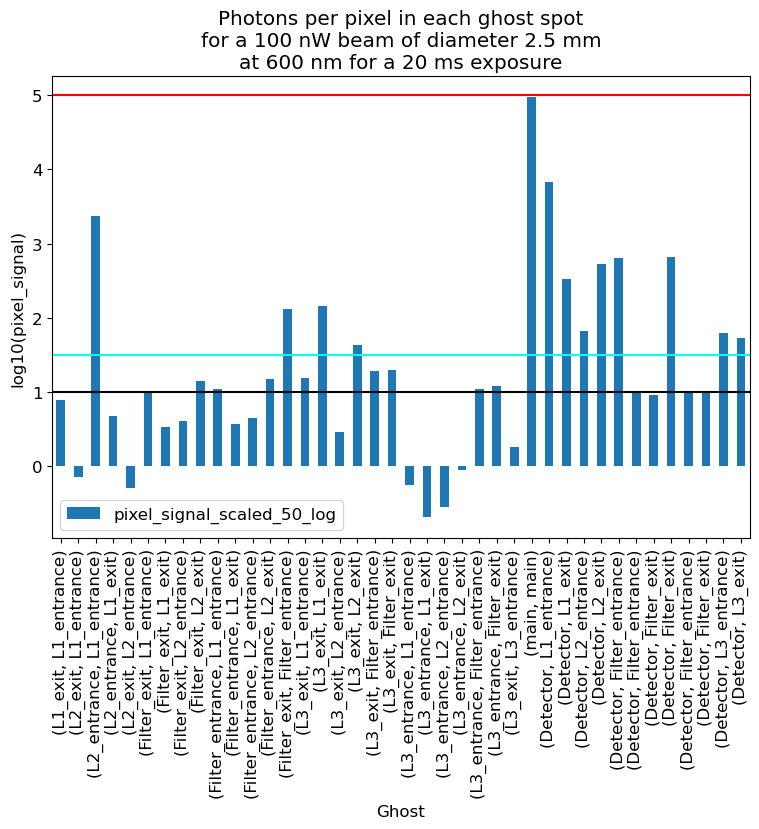

In [15]:
plt.rcParams["figure.figsize"] = [9, 6]
spots_data_frame.plot.bar("name", "pixel_signal_scaled_50_log")
plt.xlabel("Ghost")
plt.ylabel("log10(pixel_signal)")
plt.axhline(5, color="red")
plt.axhline(1, color="black")
plt.axhline(1.5, color="cyan")
plt.title("Photons per pixel in each ghost spot\nfor a 100 nW beam of diameter 2.5 mm\nat 600 nm for a 20 ms exposure")

In [16]:
# Counting number of ghosts with more than 1 p.e. of signal
n_spots_above_1pe = spots_data_frame[spots_data_frame["pixel_signal_scaled_50"]>=1]["index"].count()
print(f'{n_spots_above_1pe} ghosts spots out of 41 should have more than 1 p.e. of signal per pixel')
n_spots_above_5pe = spots_data_frame[spots_data_frame["pixel_signal_scaled_50"]>=5]["index"].count()
print(f'{n_spots_above_5pe} ghosts spots out of 41 should have more than 5 p.e. of signal per pixel')
n_spots_above_10pe = spots_data_frame[spots_data_frame["pixel_signal_scaled_50"]>=10]["index"].count()
print(f'{n_spots_above_10pe} ghosts spots out of 41 should have more than 10 p.e. of signal per pixel')

34 ghosts spots out of 41 should have more than 1 p.e. of signal per pixel
27 ghosts spots out of 41 should have more than 5 p.e. of signal per pixel
23 ghosts spots out of 41 should have more than 10 p.e. of signal per pixel


### Conclusions
- When setting the light flux so as not to saturate the main spot for the thoughput measurement, from 25% to 50% of the ghosts spots will not be detectable anymore.
- One shall also consider the presence of the filter that implies that all the ghosts spots might not be that useful and the fit convergence might be harder (but we'll have much more data).
- Another point to check is if the ghosts spots are far enough one from each other in the expected throughput beam configuration, more spots means more possible overlaps and undetectable deem spots might just add noise to other spots.
- Then, half of the throughput data, the ones that target 1 focal plane position, will be taken at a "high" angles (>10°), implying that most ghosts spots will be out of the camera.
- I need to be able to read Andy's configs to simulate a few of these to see where the ghosts are.

# Run the full simulation and analysis with no filter

Direct path is number 14
  central impact point is (-0.079497, 0.164221)
  transmission is 0.8383

Maximum expected flux is 0.8383
Maximum bin content is 626.1795


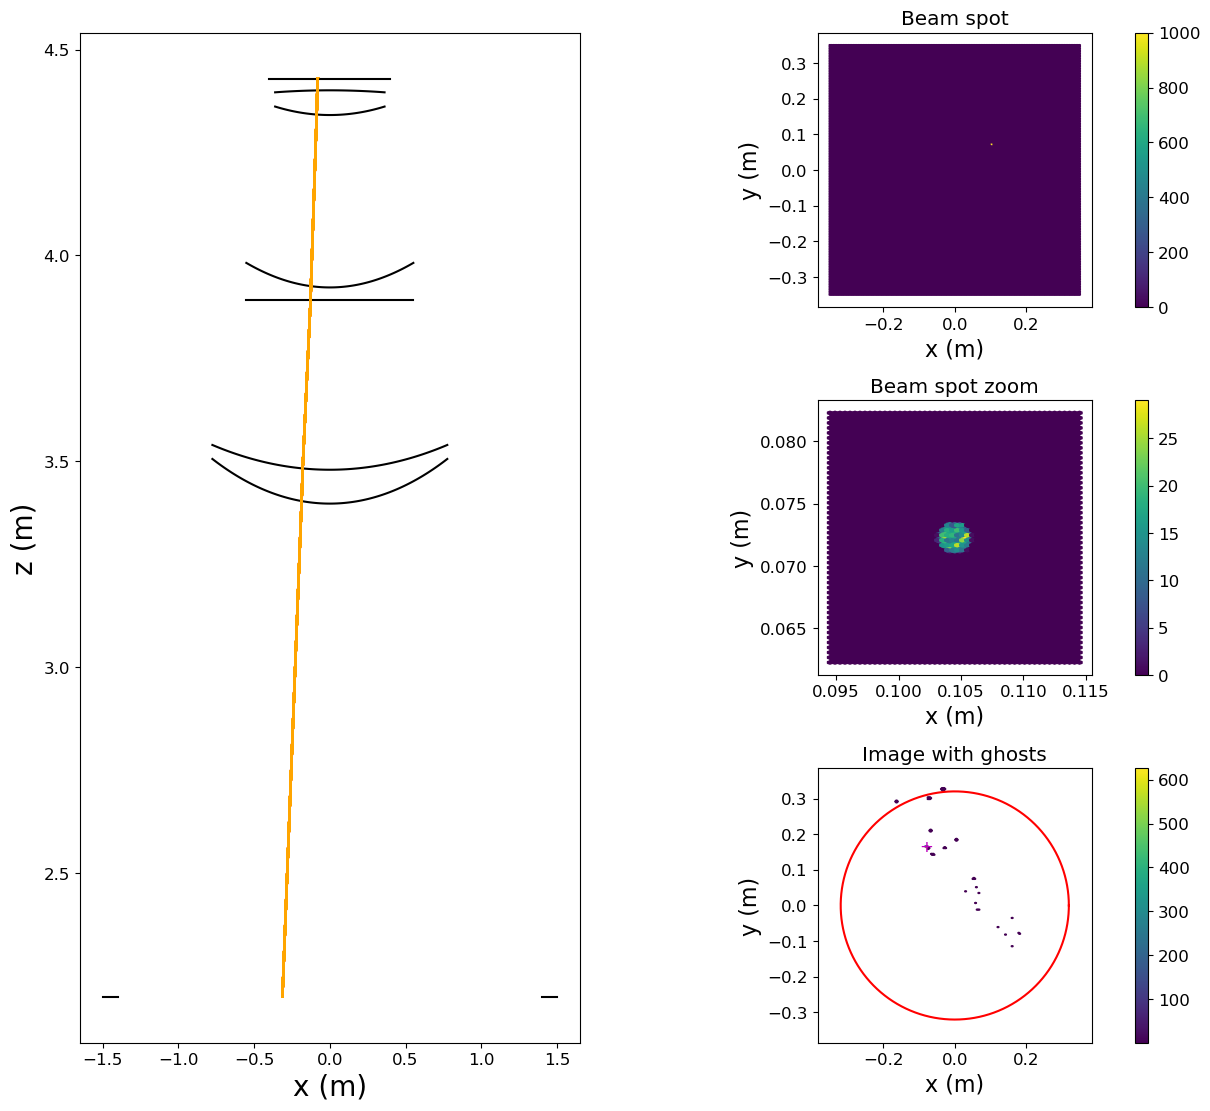

<AxesSubplot:title={'center':'Ghosts representation'}, xlabel='x (m)', ylabel='y (m)'>

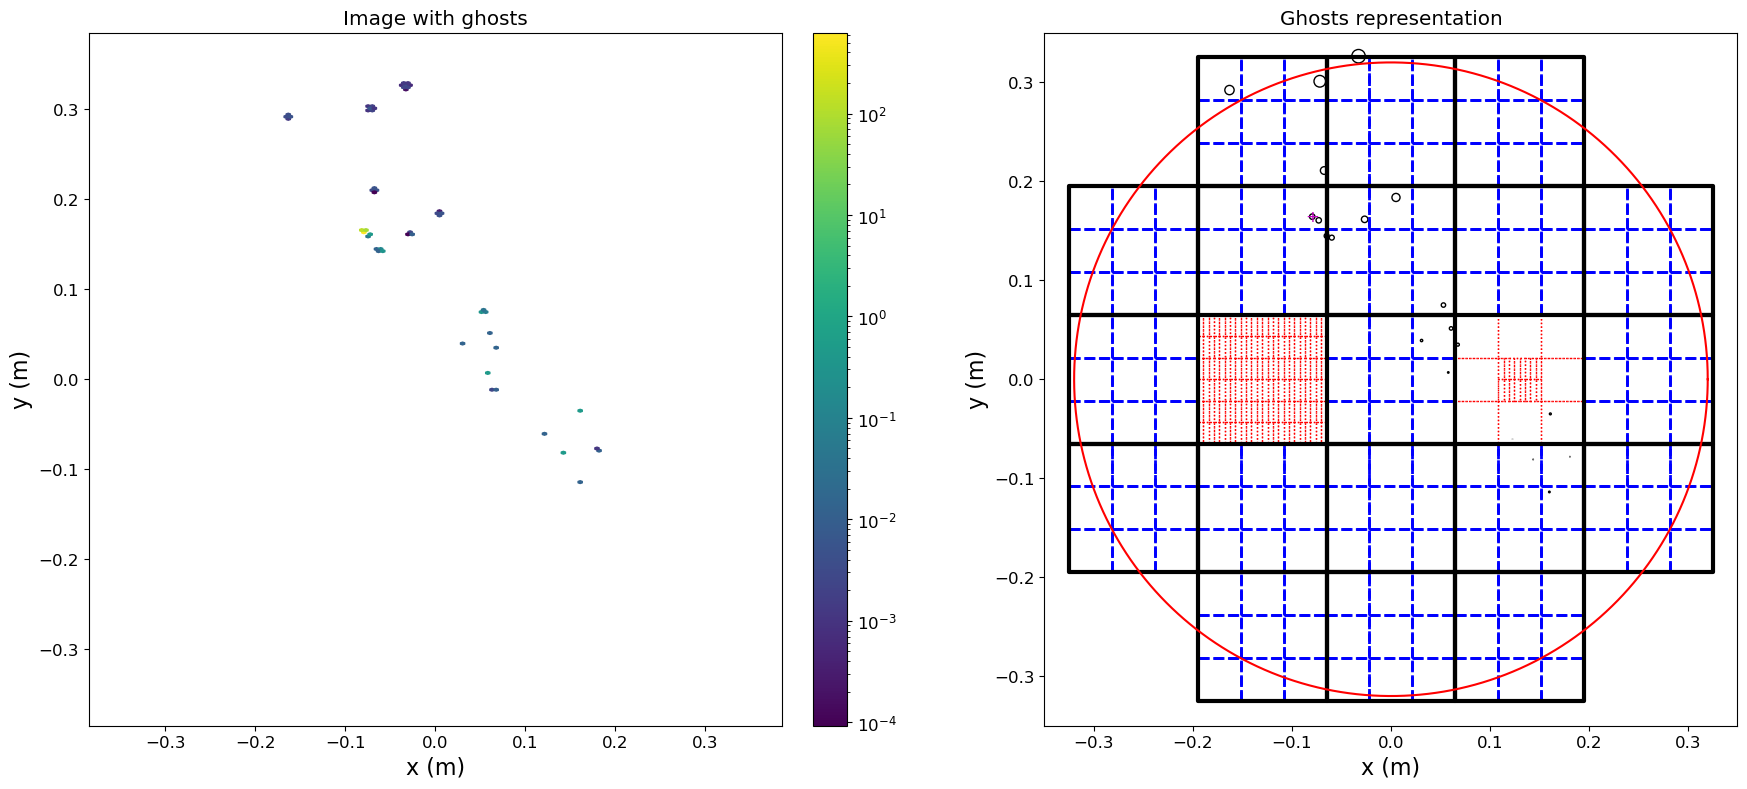

In [17]:
# Second CCOB like geometry, i.e. lenses + filters
telescope_nof = batoid.Optic.fromYaml("../data/LSST_CCOB_r.yaml")

# Make refractive interfaces partially reflective
# Call on current telescope, smart coating is [lens, filter, camera]
tweak_optics.make_optics_reflective(telescope_nof, coating='smart',
                                    r_frac=[lens_reflectivity_600nm, filter_reflectivity_600nm, ccd_reflectivity_600nm])

# Run simulation with standard beam config
trace_full_nof, r_forward_nof, r_reverse_nof, rays_nof = simulator.run_simulation(telescope_nof, beam_config=BEAM_CONFIG_600)
simulation_nof = [trace_full_nof, r_forward_nof, r_reverse_nof, rays_nof]
# Check setup
plotter.plot_setup(telescope_nof, simulation_nof)

# camera and ghosts visualization
spots_data_nof, _spots = reduce_ghosts(r_forward_nof)
spots_data_frame_nof = make_data_frame(spots_data_nof)
_fig, ax_nof = plotter.plot_full_camera_and_spots(r_forward_nof, spots_data_frame_nof, log_scale=True)
camera_nof = build_camera()
show_camera(ax_nof[1], camera_nof)


In [18]:
# compute pixel signal log10
spots_data_frame_nof["pixel_signal_log"] = np.log10(spots_data_frame_nof["pixel_signal"])

In [19]:
spots_data_frame_nof.sort_values('pixel_signal', axis=0)

beam_id  geom_id  index                        name     pos_x     std_x  \
10        0        0     10      (L3_entrance, L1_exit) -0.032728  0.001606   
11        0        0     11  (L3_entrance, L2_entrance) -0.071834  0.001373   
4         0        0      4      (L2_exit, L2_entrance) -0.163081  0.001093   
9         0        0      9  (L3_entrance, L1_entrance)  0.005113  0.000965   
1         0        0      1      (L2_exit, L1_entrance) -0.067368  0.000917   
12        0        0     12      (L3_entrance, L2_exit) -0.026564  0.000770   
13        0        0     13      (L3_exit, L3_entrance) -0.064946  0.000584   
7         0        0      7      (L3_exit, L2_entrance)  0.060764  0.000417   
3         0        0      3      (L2_entrance, L1_exit)  0.067595  0.000356   
0         0        0      0      (L1_exit, L1_entrance)  0.030954  0.000278   
5         0        0      5      (L3_exit, L1_entrance)  0.160039  0.000190   
20        0        0     20         (Detector, L3_exit) -0.072941  0.000642   
8         0        0      8          (L3_exit, L2_exit)  0.065436  0.000101   
19        0        0     19     (Detector, L3_entrance) -0.059732  0.000587   
17        0        0     17     (Detector, L2_entrance)  0.053042  0.000522   
6         0        0      6          (L3_exit, L1_exit)  0.180791  0.000048   
16        0        0     16         (Detector, L1_exit)  0.161023  0.000226   
18        0        0     18         (Detector, L2_exit)  0.057927  0.000178   
2         0        0      2  (L2_entrance, L1_entrance)  0.122797  0.000018   
15        0        0     15     (Detector, L1_entrance)  0.143653  0.000058   
14        0        0     14                (main, main) -0.079497  0.000645   

       pos_y     std_y   width_x   width_y    radius    radius_err  \
10  0.326261  0.001606  0.006139  0.006140  0.003070  6.937211e-07   
11  0.300965  0.001373  0.005247  0.005369  0.002654  6.081498e-05   
4   0.292077  0.001093  0.004173  0.004306  0.002120  6.617508e-05   
9   0.183604  0.000965  0.003687  0.003694  0.001845  3.142160e-06   
1   0.210802  0.000917  0.003502  0.003502  0.001751  2.825632e-07   
12  0.161506  0.000770  0.002939  0.002949  0.001472  4.845725e-06   
13  0.144790  0.000584  0.002229  0.002241  0.001118  5.858914e-06   
7   0.051329  0.000417  0.001596  0.001588  0.000796  4.031813e-06   
3   0.034926  0.000356  0.001360  0.001372  0.000683  5.879111e-06   
0   0.039095  0.000278  0.001062  0.001078  0.000535  8.209677e-06   
5  -0.113878  0.000190  0.000723  0.000739  0.000365  8.170218e-06   
20  0.160503  0.000642  0.002454  0.002453  0.001227  4.841549e-07   
8  -0.011130  0.000101  0.000390  0.000382  0.000193  4.028802e-06   
19  0.143013  0.000587  0.002243  0.002252  0.001124  4.620533e-06   
17  0.074923  0.000522  0.001996  0.001988  0.000996  4.100729e-06   
6  -0.078243  0.000048  0.000185  0.000202  0.000097  8.255921e-06   
16 -0.035029  0.000226  0.000866  0.000880  0.000437  6.929545e-06   
18  0.006835  0.000178  0.000682  0.000680  0.000341  6.261195e-07   
2  -0.060483  0.000018  0.000072  0.000068  0.000035  2.466365e-06   
15 -0.081048  0.000058  0.000221  0.000228  0.000112  3.422568e-06   
14  0.164221  0.000645  0.002465  0.002465  0.001233  1.713198e-07   

          flux    surface  n_pixels  pixel_signal  pixel_signal_log  
10    0.013199  29.605621    266451  1.271781e+01          1.104412  
11    0.013305  22.130445    199174  1.715054e+01          1.234278  
4     0.013412  14.115398    127039  2.710541e+01          1.433056  
9     0.013093  10.696439     96268  3.491934e+01          1.543066  
1     0.013199   9.632080     86689  3.909007e+01          1.592066  
12    0.013412   6.807918     61271  5.619981e+01          1.749735  
13    0.013412   3.923651     35313  9.751217e+01          1.989059  
7     0.013199   1.989401     17905  1.892623e+02          2.277064  
3     0.013412   1.465779     13192  2.610242e+02          2.416681  
0     0.013412   0.89931

Text(0.5, 1.0, 'Photons per pixel in each ghost spot\nfor a 100 nW beam of diameter 2.5 mm\nat 600 nm for a 1 s exposure')

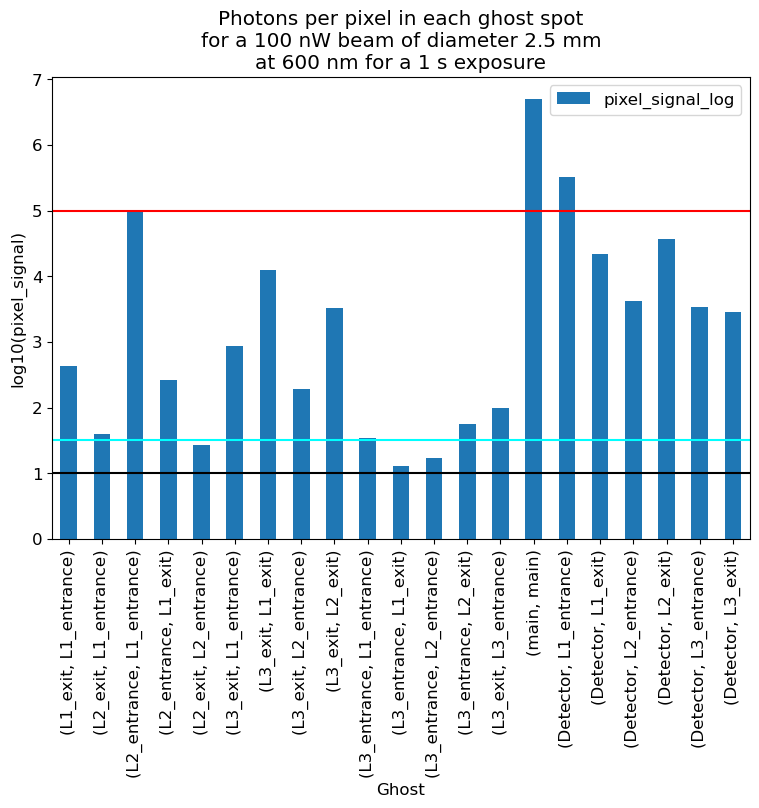

In [20]:
plt.rcParams["figure.figsize"] = [9, 6]
spots_data_frame_nof.plot.bar("name", "pixel_signal_log")
plt.xlabel("Ghost")
plt.ylabel("log10(pixel_signal)")
plt.axhline(5, color="red")
plt.axhline(1, color="black")
plt.axhline(1.5, color="cyan")
plt.title("Photons per pixel in each ghost spot\nfor a 100 nW beam of diameter 2.5 mm\nat 600 nm for a 1 s exposure")

## Conclusions
- Conclusions are similar to the simulation with the filter.

# Read a few configurations prepared for step 9, and check impact points

In [21]:
# Read Andy's configs for step 9
def read_ccob_config(file_path):
    # define headers
    col_names = 'x y u b lambda sens rebs id expose'.split(' ')
    # ingest
    tg = pd.read_csv(file_path, sep=" ", header=None, names=col_names)
    # strip useless strings    
    for col in col_names:
        tg[col] = tg[col].str.strip(f'{col}=')
    # convert id to int
    tg['id'] = tg['id'].apply(int, base=16)
    # convert string to floats
    f_cols = 'x y u b lambda expose'.split(' ')
    for col in f_cols:
        tg[col] = tg[col].astype(float)    
    return tg

def get_ccd(ccd, df):
    return df[(df['sens']==ccd) & (tg['u']<10)]

from scipy.spatial.transform import Rotation as transform_rotation

def build_beam_config(df, id):
    cc = df[df['id']==id]
    beam_conf = copy.deepcopy(BEAM_CONFIG_0)
    beam_conf['beam_id'] = cc['id'].values[0]
    beam_conf['wl'] = cc['lambda'].values[0]    
    beam_conf['n_photons'] = 100
    beam_conf['x_offset'] = cc['x'].values[0]/1000.
    beam_conf['y_offset'] = cc['y'].values[0]/1000.
    beam_conf['z_offset'] = 2.797472 # 2.797472
    # u=theta u=phi validated
    theta = cc['u'].values[0]
    phi = cc['b'].values[0]
    rot = transform_rotation.from_rotvec([0, phi, theta], degrees=True)
    eulers = rot.as_euler('zyx', degrees=True)
    beam_conf['z_euler'] = eulers[0]
    beam_conf['y_euler'] = eulers[1]
    beam_conf['x_euler'] = eulers[2]
    return beam_conf

def build_beam_set(df):
    beam_set = [build_beam_config(df, id) for id in df['id'].to_list()]
    return beam_set


In [22]:
tg = read_ccob_config('../data/ccob_step9_targets.txt')
tg.head()

x       y         u        b  lambda     sens      rebs    id  expose
0  390.34 -925.18  110.7516  24.3545   542.0  R30_S11  R30/Reb1  5748     0.1
1  390.34 -925.18  119.4588  25.8982   542.0  R20_S11  R20/Reb1  5749     0.1
2 -200.00 -422.23   33.7841  18.8957   542.0  R41_S11  R41/Reb1  5750     0.1
3 -200.00 -422.23   42.8425  15.6701   542.0  R31_S11  R31/Reb1  5751     0.1
4 -200.00 -422.23   52.6456  18.7542   542.0  R32_S11  R32/Reb1  5752     0.1

In [23]:
# Select a bunch of interesting configuration
r22_s11 = get_ccd('R22_S11', tg)
r33_s11 = get_ccd('R33_S11', tg)
r11_s11 = get_ccd('R11_S11', tg)
r22_s11.head(10)

x      y       u        b   lambda     sens      rebs    id  expose
222   532.06  19.87  0.4853 -18.0387  546.576  R22_S11  R22/Reb1  5970     0.1
246   576.22  21.60  1.5927 -19.3238  646.420  R22_S11  R22/Reb1  5994     0.1
384   495.12  27.75  1.8475 -16.7484  586.398  R22_S11  R22/Reb1  6132     0.1
847   641.93  58.91  4.1044 -21.5264  569.979  R22_S11  R22/Reb1  6595     0.1
1151 -522.42 -61.19  7.9413  18.5212  570.857  R22_S11  R22/Reb1  6899     0.1
1279 -613.28 -50.57  5.9643  21.2949  555.990  R22_S11  R22/Reb1  7027     0.1
1529 -523.71 -36.67  4.7855  18.4156  557.502  R22_S11  R22/Reb1   454     0.1
1576 -657.11 -62.87  6.4788  22.5391  605.567  R22_S11  R22/Reb1  7324     0.1
2419 -442.26  -1.91  1.9498  15.7742  677.969  R22_S11  R22/Reb1  8167     0.1
2461  499.43  52.71  5.2567 -16.8037  574.260  R22_S11  R22/Reb1  8209     0.1

In [24]:
# Map to a ghosts beam config
r22_s11_beam_set = build_beam_set(r22_s11)
r11_s11_beam_set = build_beam_set(r11_s11)
r33_s11_beam_set = build_beam_set(r33_s11)

In [25]:
r22_s11_beam_set[0]

{'beam_id': 5970,
 'wl': 546.576,
 'n_photons': 100,
 'radius': 0.00125,
 'x_offset': 0.53206,
 'y_offset': 0.019870000000000002,
 'z_offset': 2.797472,
 'z_euler': 0.5019965090762478,
 'y_euler': -18.038475402105416,
 'x_euler': 0.07968172138016288}

In [26]:
impacts_r22_s11 = simulator.simulate_impact_points_for_beam_set(telescope, r22_s11_beam_set)

In [27]:
impacts_r22_s11.head(20)

beam_id       wl  n_photons   radius  x_offset  y_offset  z_offset  \
5970     5970  546.576        100  0.00125   0.53206   0.01987  2.797472   
5994     5994  646.420        100  0.00125   0.57622   0.02160  2.797472   
6132     6132  586.398        100  0.00125   0.49512   0.02775  2.797472   
6595     6595  569.979        100  0.00125   0.64193   0.05891  2.797472   
6899     6899  570.857        100  0.00125  -0.52242  -0.06119  2.797472   
7027     7027  555.990        100  0.00125  -0.61328  -0.05057  2.797472   
454       454  557.502        100  0.00125  -0.52371  -0.03667  2.797472   
7324     7324  605.567        100  0.00125  -0.65711  -0.06287  2.797472   
8167     8167  677.969        100  0.00125  -0.44226  -0.00191  2.797472   
8209     8209  574.260        100  0.00125   0.49943   0.05271  2.797472   
8426     8426  658.787        100  0.00125   0.56822   0.02499  2.797472   

       z_euler    y_euler   x_euler    x_spot    y_spot  beam_dist_to_center  \
5970  0.501997 -18.038475  0.079682  0.006121  0.017460             0.532431   
5994  1.655958 -19.321193  0.281905  0.009931  0.013151             0.576625   
6132  1.901972 -16.745395  0.279958  0.009323  0.019449             0.495897   
6595  4.308847 -21.506893  0.818701  0.005190  0.034120             0.644627   
6899  8.228769  18.459383 -1.339388  0.016858 -0.021347             0.525991   
7027  6.254292  21.254218 -1.174647  0.015472 -0.014956             0.615361   
454   4.957136  18.393275 -0.803070  0.013480 -0.012734             0.524992   
7324  6.834025  22.487939 -1.360174  0.012108 -0.021318             0.660111   
8167  2.000591  15.771060 -0.277118  0.013733  0.006179             0.442264   
8209  5.412505 -16.779297  0.798831  0.012686  0.029192             0.502204   
8426  1.621781 -18.997938  0.271381  0.011990  0.016876             0.568769   

      spot_dist_to_center  convergence  displacement  
5970             0.018502     0.034750     -0.513929  
5994             0.016480     0.028580     -0.560145  
6132             0.021568     0.043492     -0.474329  
6595             0.034512     0.053538     -0.610115  
6899             0.027200     0.051712     -0.498791  
7027             0.021519     0.034970     -0.593842  
454              0.018544     0.035322     -0.506448  
7324             0.024517     0.037140     -0.635594  
8167             0.015059     0.034050     -0.427205  
8209             0.031829     0.063379     -0.470375  
8426             0.020702     0.036397     -0.548068

<AxesSubplot:title={'center':'Beam set impact points'}, xlabel='Camera X', ylabel='Camera Y'>

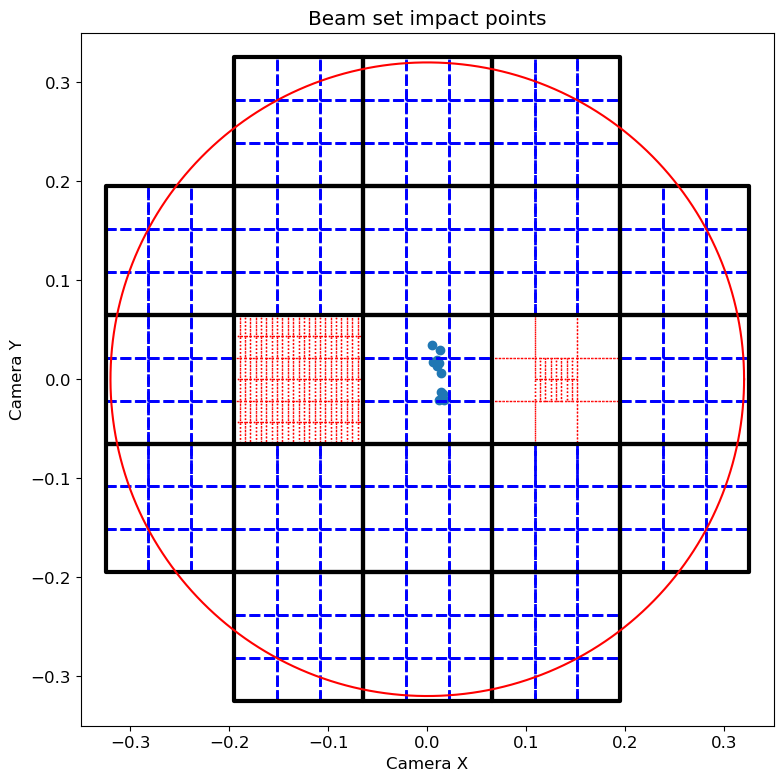

In [28]:
plotter.plot_impact_points_full_frame(impacts_r22_s11)
camera = build_camera()
show_camera(plt.gca(), camera)

<AxesSubplot:title={'center':'Beam set impact points'}, xlabel='Camera X', ylabel='Camera Y'>

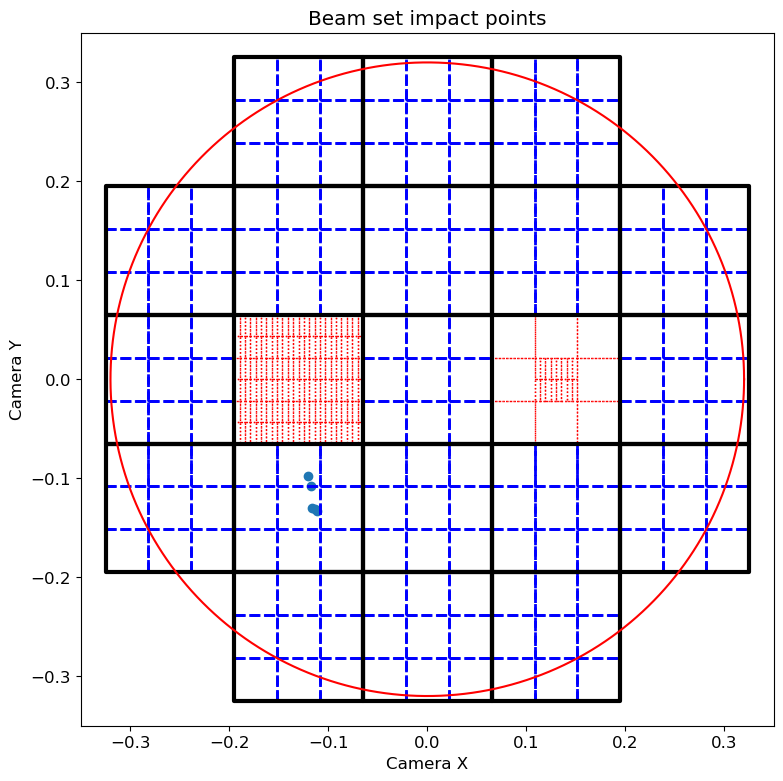

In [29]:
impacts_r11_s11 = simulator.simulate_impact_points_for_beam_set(telescope, r11_s11_beam_set)
plotter.plot_impact_points_full_frame(impacts_r11_s11)
camera = build_camera()
show_camera(plt.gca(), camera)

<AxesSubplot:title={'center':'Beam set impact points'}, xlabel='Camera X', ylabel='Camera Y'>

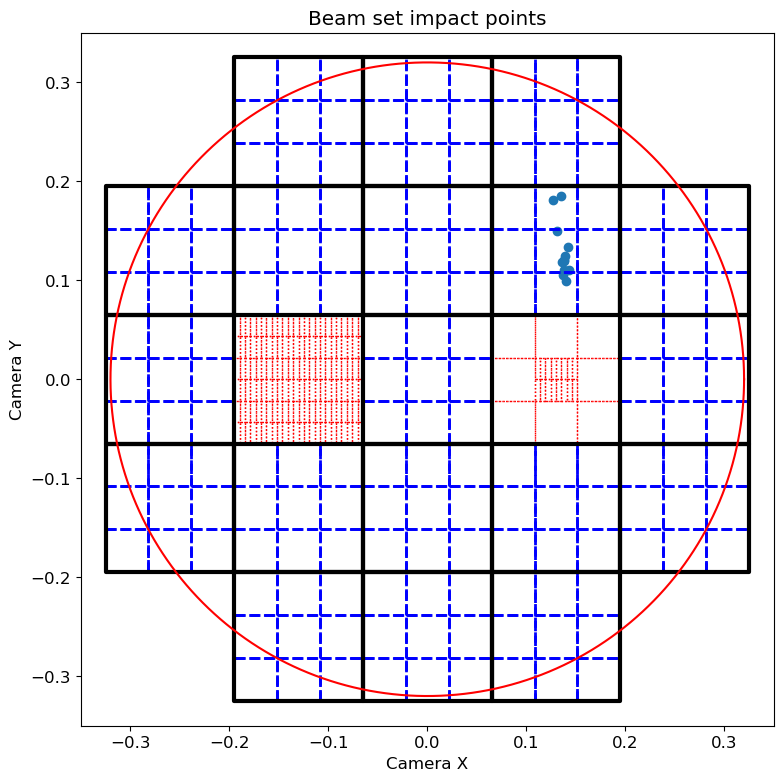

In [30]:
impacts_r33_s11 = simulator.simulate_impact_points_for_beam_set(telescope, r33_s11_beam_set)
plotter.plot_impact_points_full_frame(impacts_r33_s11)
camera = build_camera()
show_camera(plt.gca(), camera)

# Simulate a few configurations with ghosts

In [31]:
def run_throughput_with_ghosts(beam_config):
    # build a telescope as integrated camera with filter
    telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r_with_filter.yaml")

    # Make refractive interfaces partially reflective
    # Call on current telescope, smart coating is [lens, filter, camera]
    tweak_optics.make_optics_reflective(telescope, coating='smart',
                                        r_frac=[lens_reflectivity_600nm, filter_reflectivity_600nm, ccd_reflectivity_600nm])

    # Run simulation with standard beam config
    trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=beam_config)
    simulation = [trace_full, r_forward, r_reverse, rays]
    # Check setup
    plotter.plot_setup(telescope, simulation)

    # camera and ghosts visualization
    spots_data, _spots = reduce_ghosts(r_forward)
    spots_data_frame = make_data_frame(spots_data)
    _fig, ax = plotter.plot_full_camera_and_spots(r_forward, spots_data_frame, log_scale=True)
    camera = build_camera()
    show_camera(ax[1], camera)
    
    # Scale fluxes from the filter simulation by a factor of 50.
    spots_data_frame["pixel_signal_scaled_50"] = spots_data_frame["pixel_signal"]/50.
    spots_data_frame["pixel_signal_scaled_50_log"] = np.log10(spots_data_frame["pixel_signal_scaled_50"])

    plt.rcParams["figure.figsize"] = [9, 6]
    spots_data_frame.plot.bar("name", "pixel_signal_scaled_50_log")
    plt.xlabel("Ghost")
    plt.ylabel("log10(pixel_signal)")
    plt.axhline(5, color="red")
    plt.axhline(1, color="black")
    plt.axhline(1.5, color="cyan")
    plt.title("Photons per pixel in each ghost spot for through put run")

    return spots_data_frame


Direct path is number 22
  central impact point is (0.006092, 0.017500)
  transmission is 0.7758

Maximum expected flux is 0.7758
Maximum bin content is 38.7881


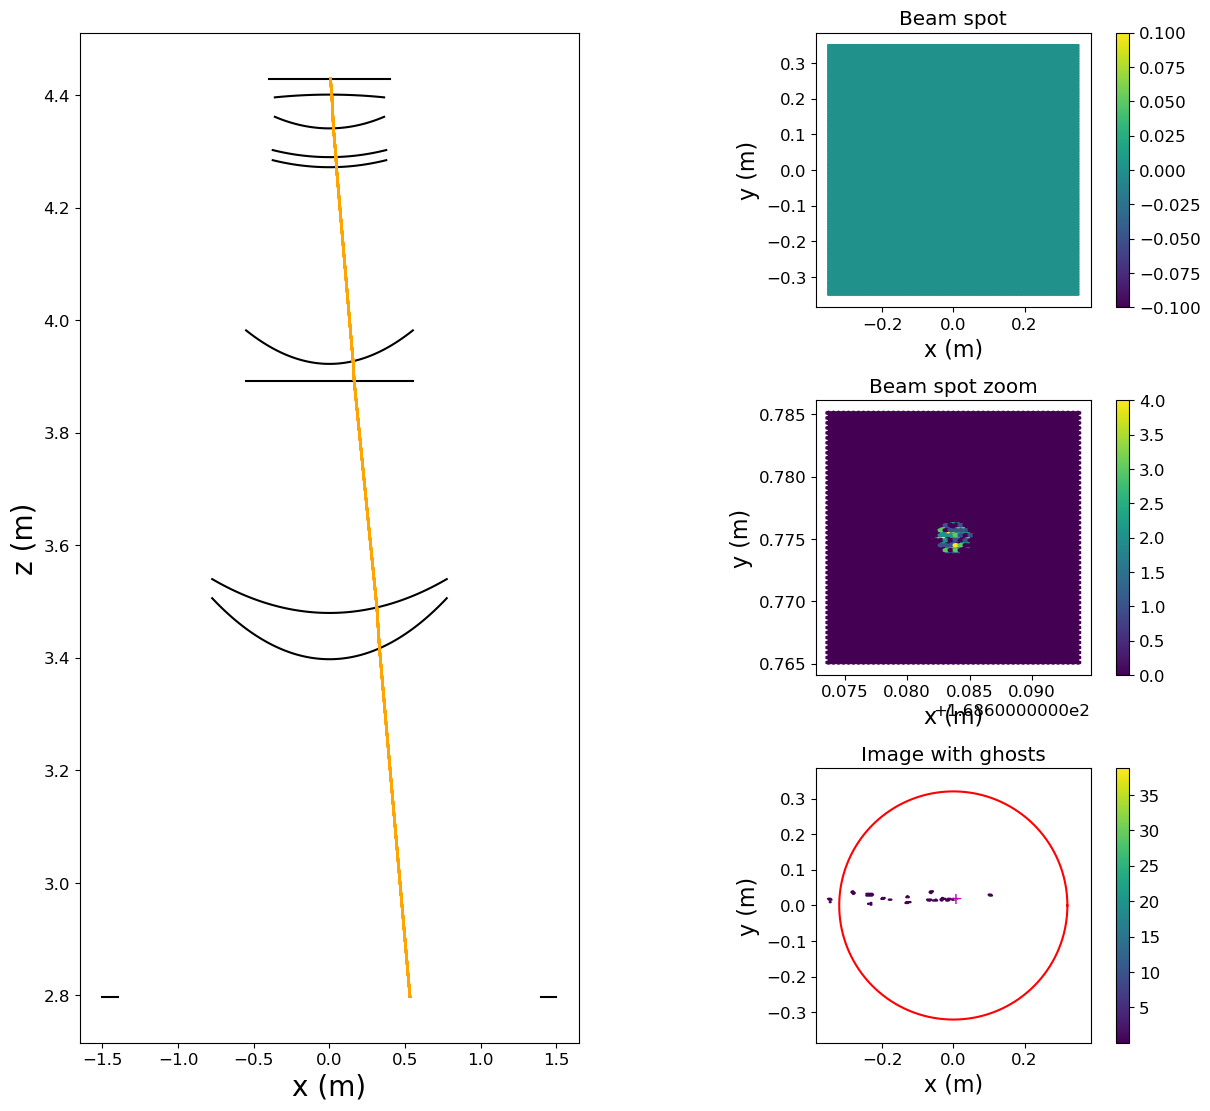

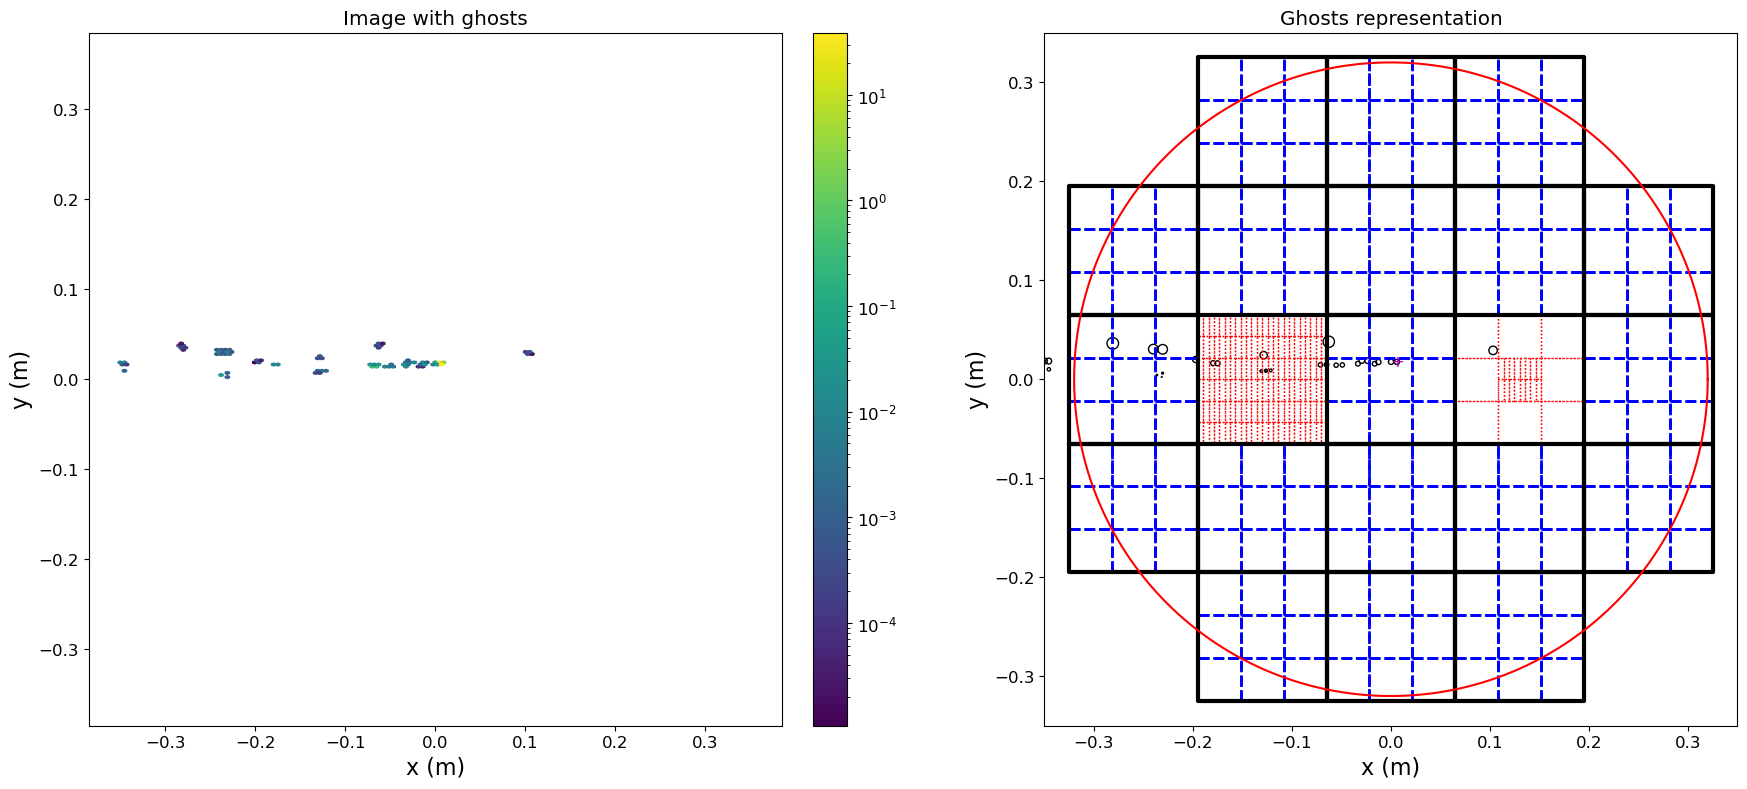

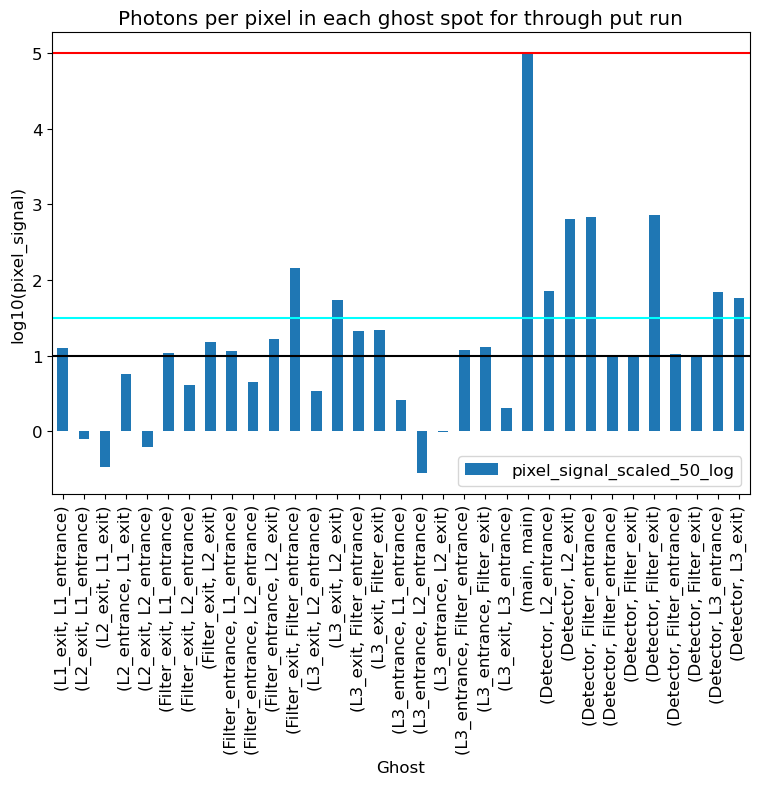

In [32]:
spots_r22_s11_0 = run_throughput_with_ghosts(r22_s11_beam_set[0])

Direct path is number 18
  central impact point is (0.009826, 0.013083)
  transmission is 0.7758

Maximum expected flux is 0.7758
Maximum bin content is 54.3033


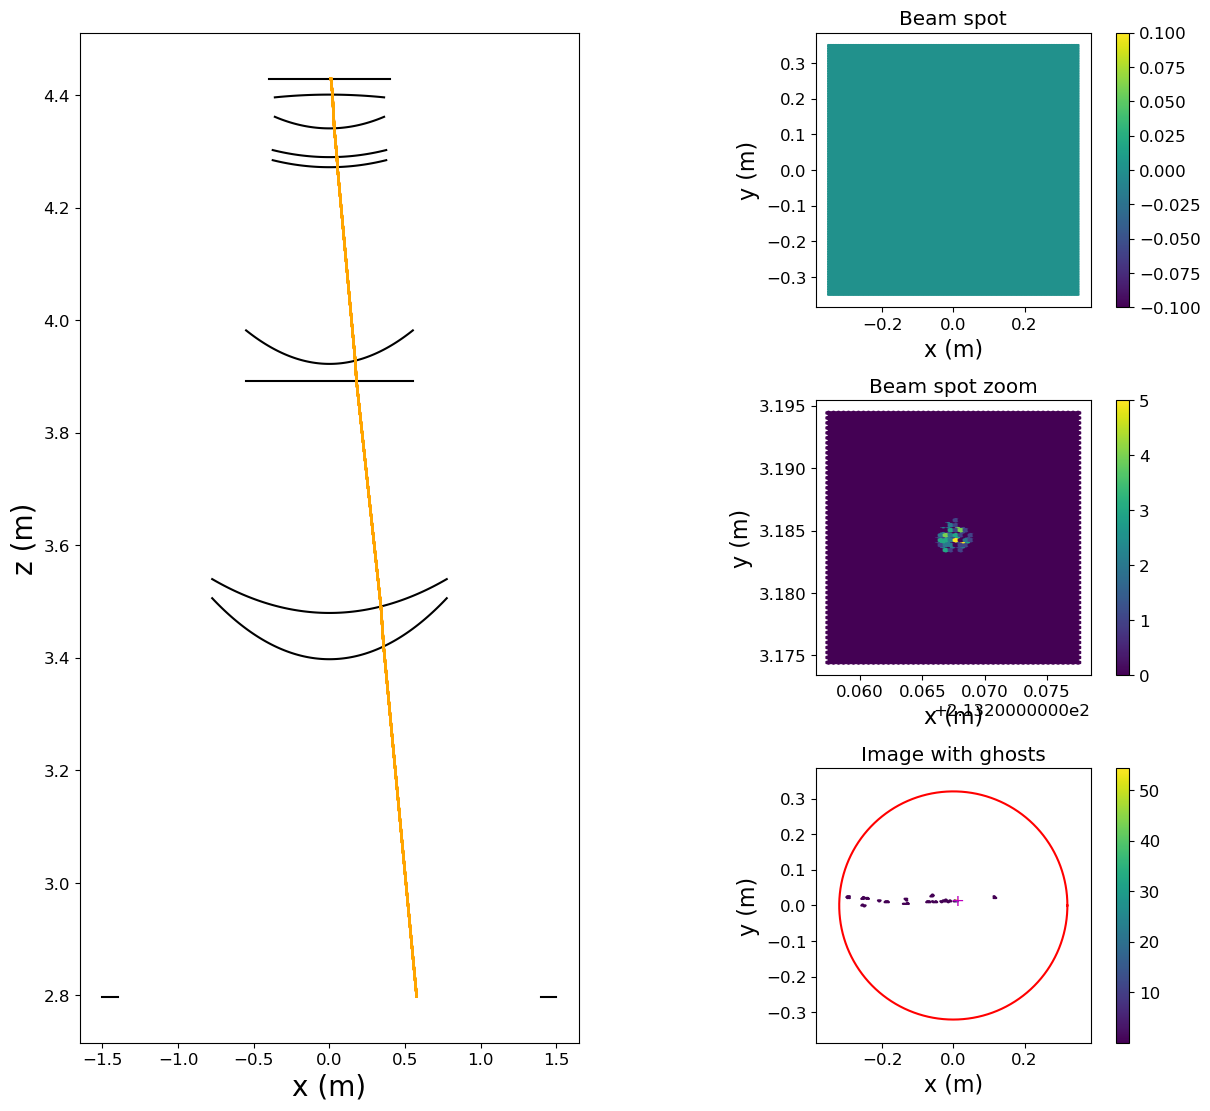

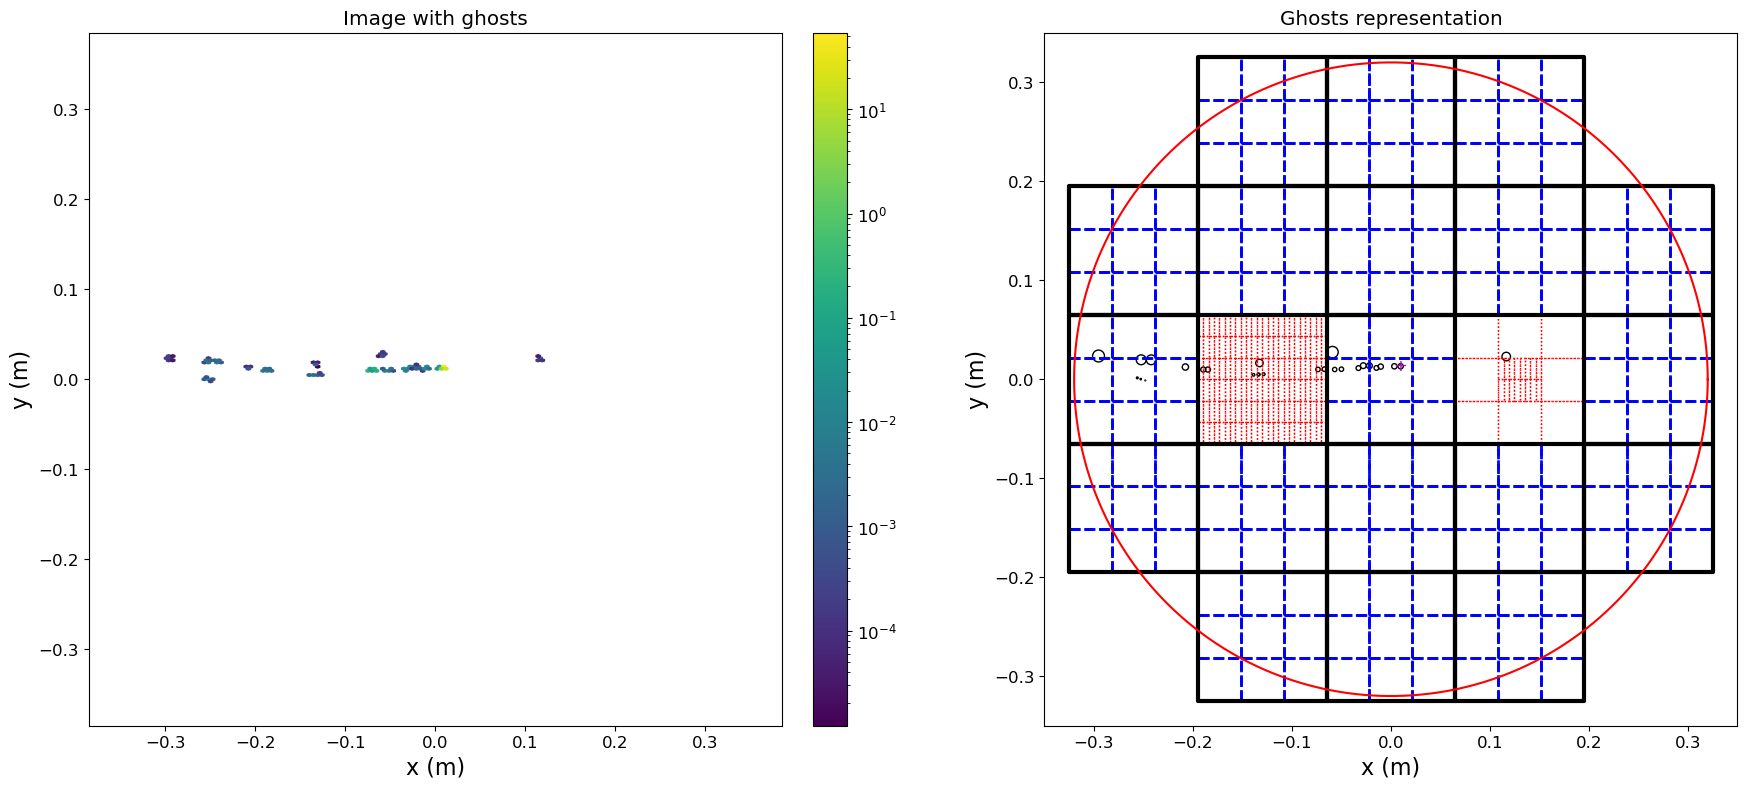

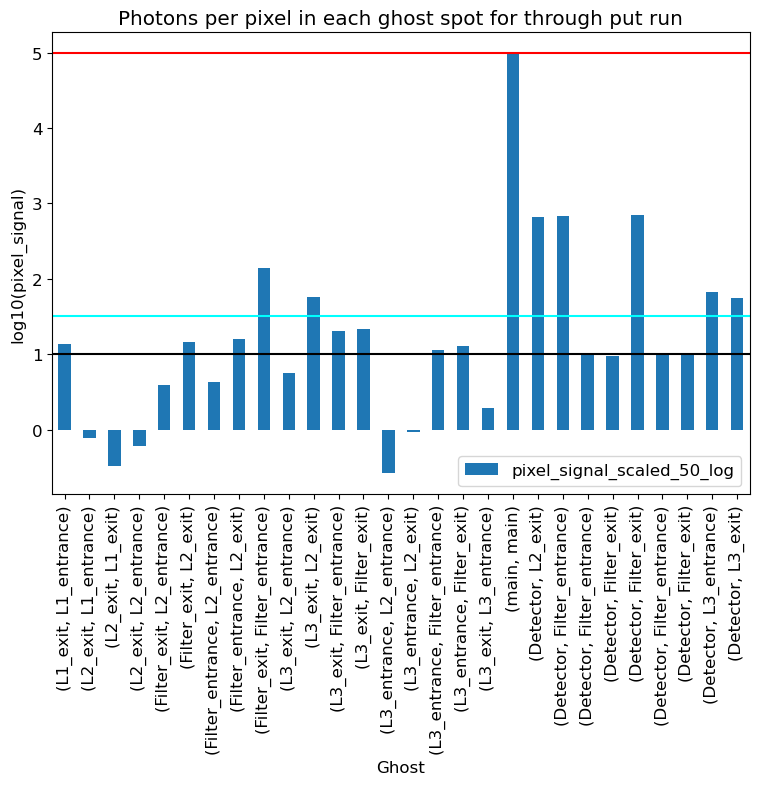

In [33]:
spots_r22_s11_1 = run_throughput_with_ghosts(r22_s11_beam_set[1])

Direct path is number 23
  central impact point is (0.009226, 0.019478)
  transmission is 0.7758

Maximum expected flux is 0.7758
Maximum bin content is 55.0791


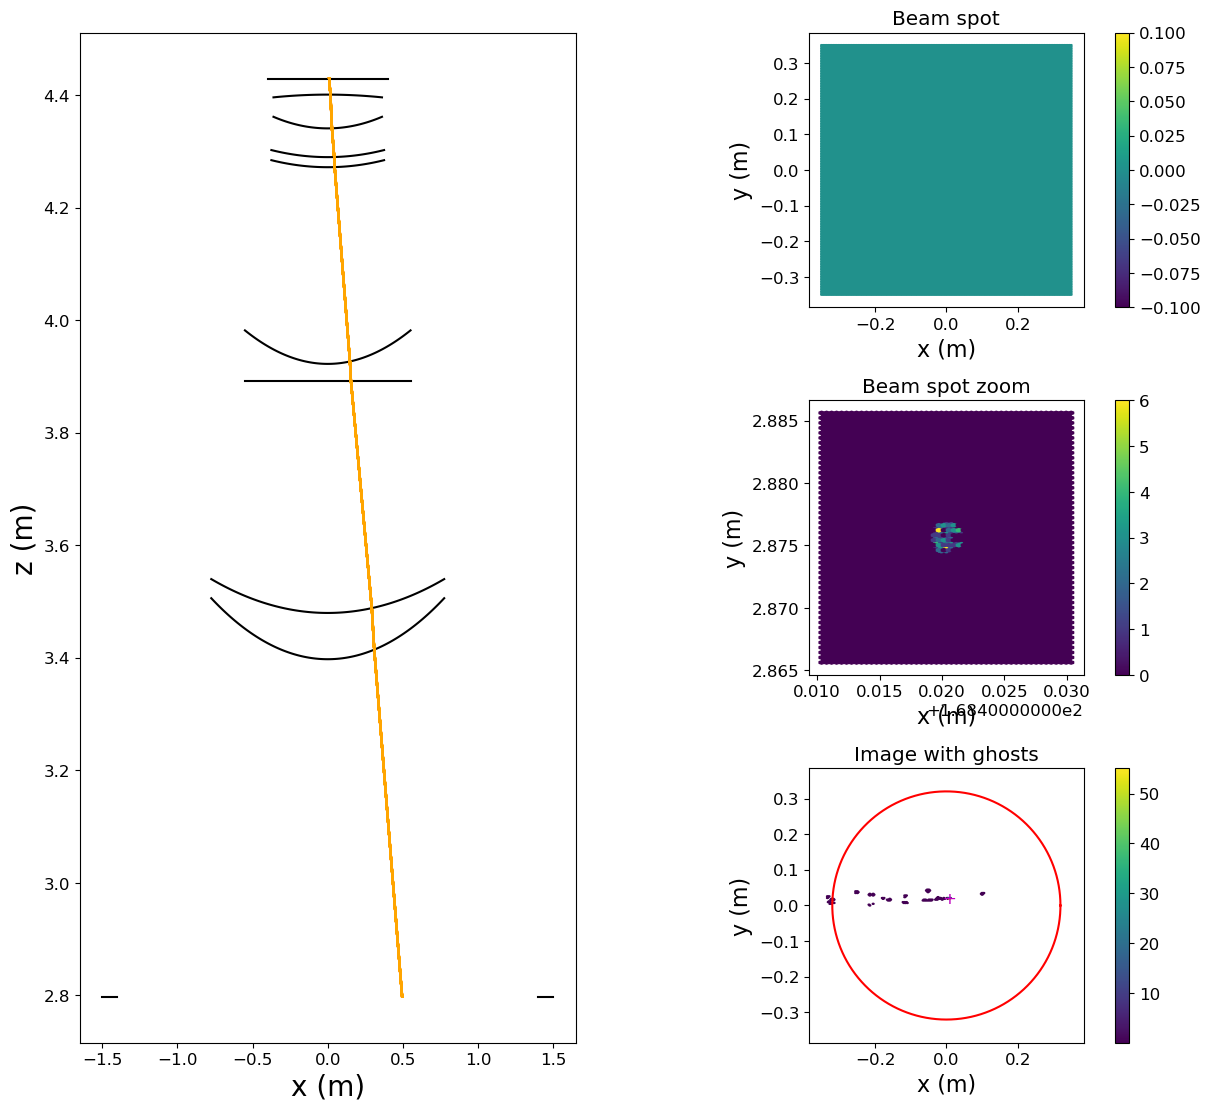

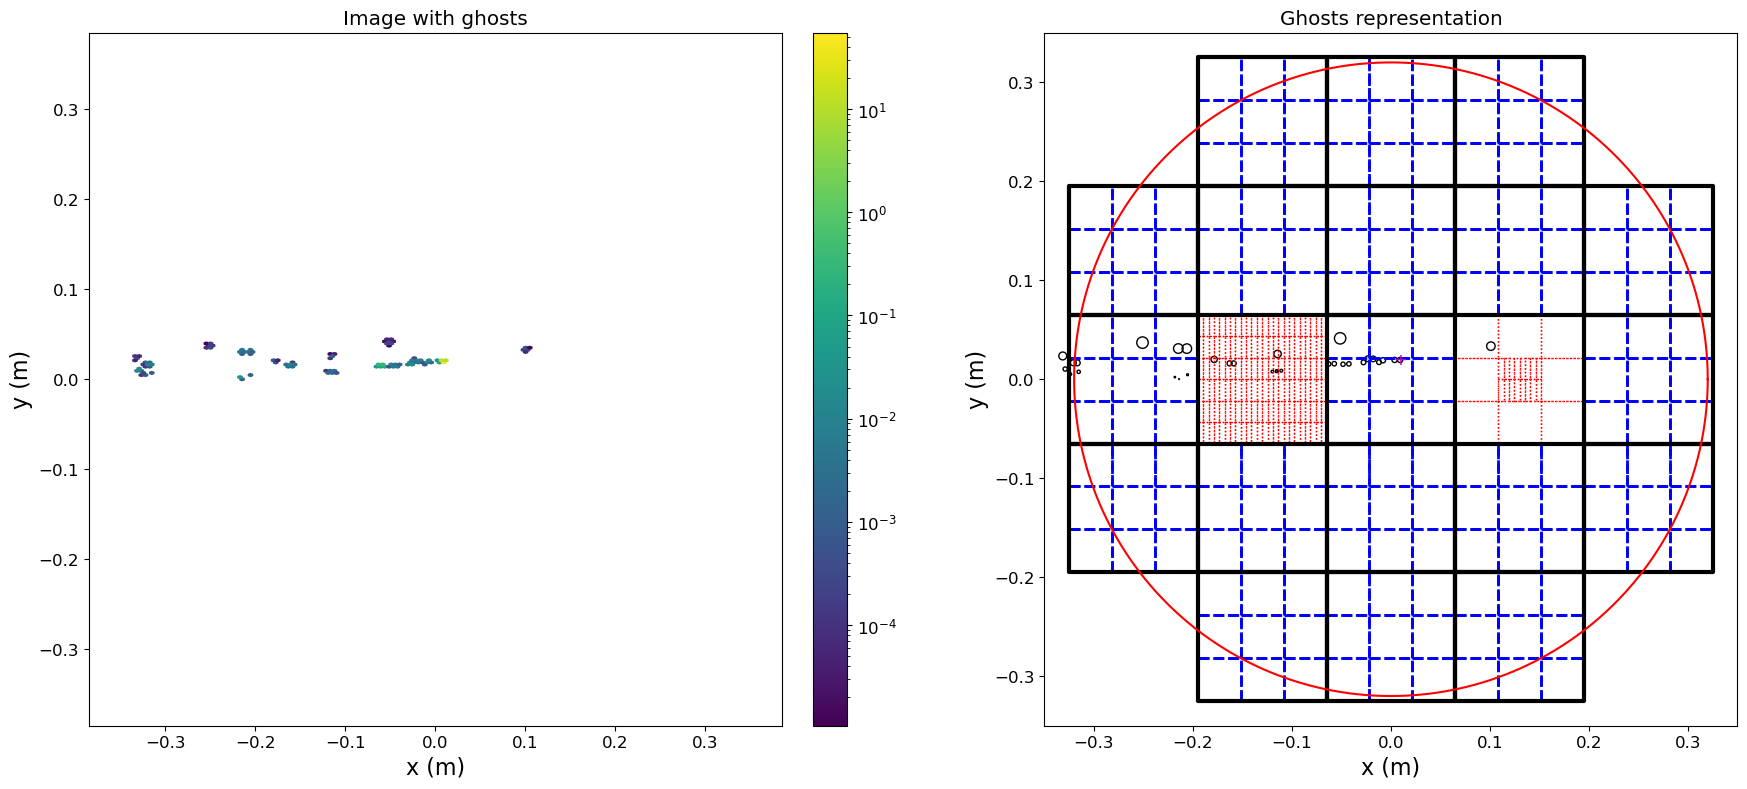

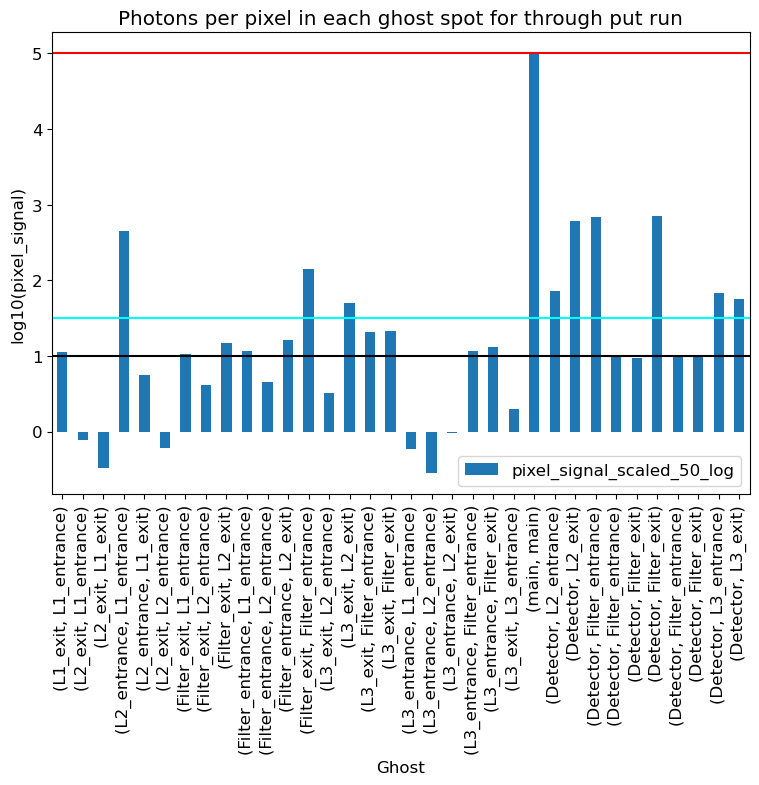

In [34]:
spots_r22_s11_2 = run_throughput_with_ghosts(r22_s11_beam_set[2])

Direct path is number 17
  central impact point is (0.005104, 0.034082)
  transmission is 0.7758

Maximum expected flux is 0.7758
Maximum bin content is 40.3396


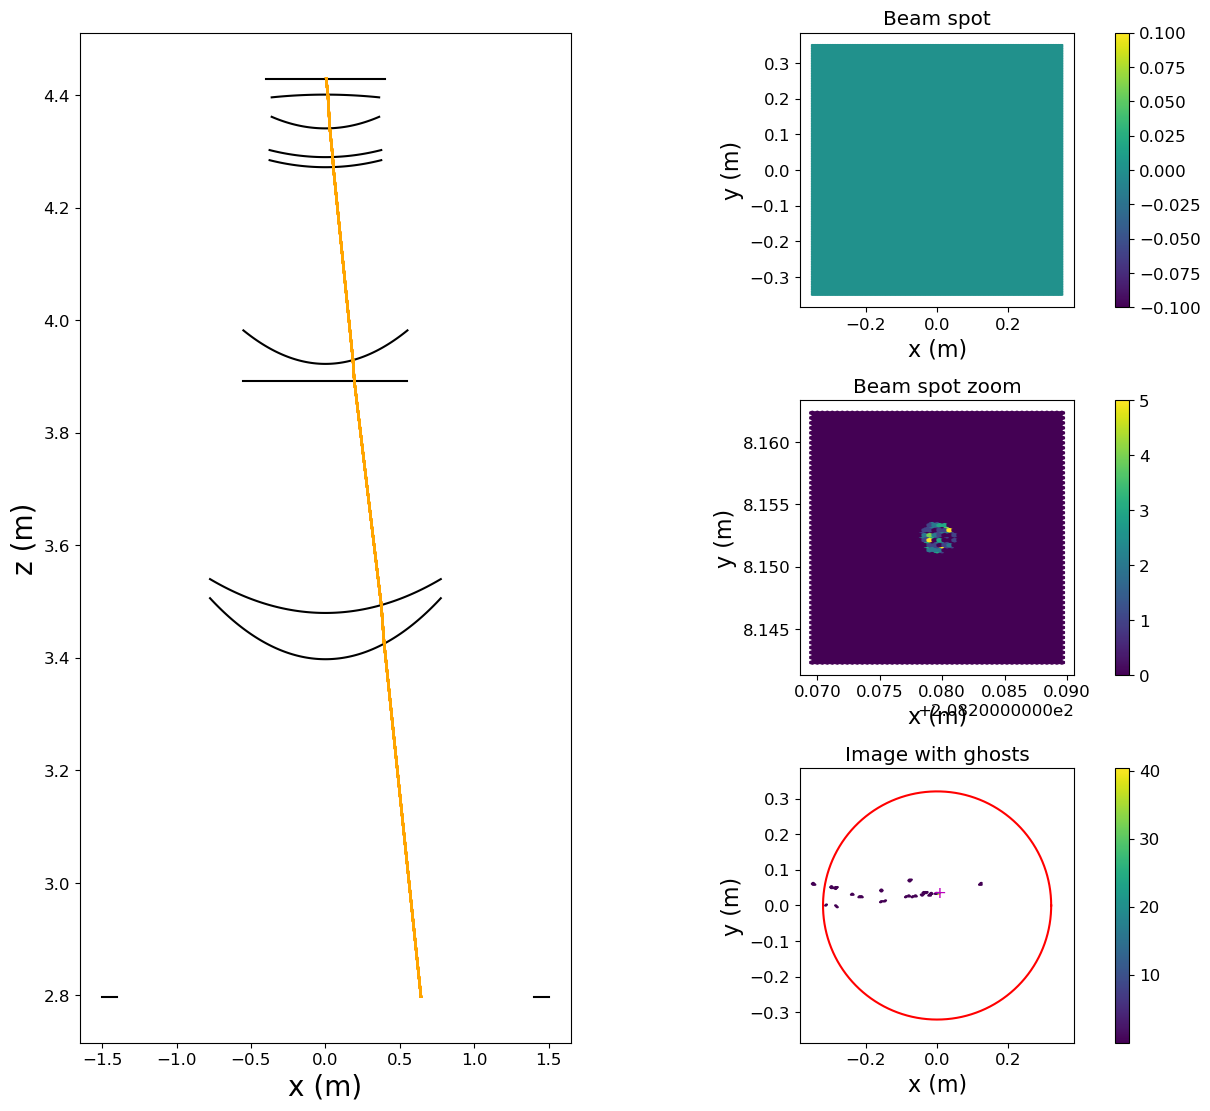

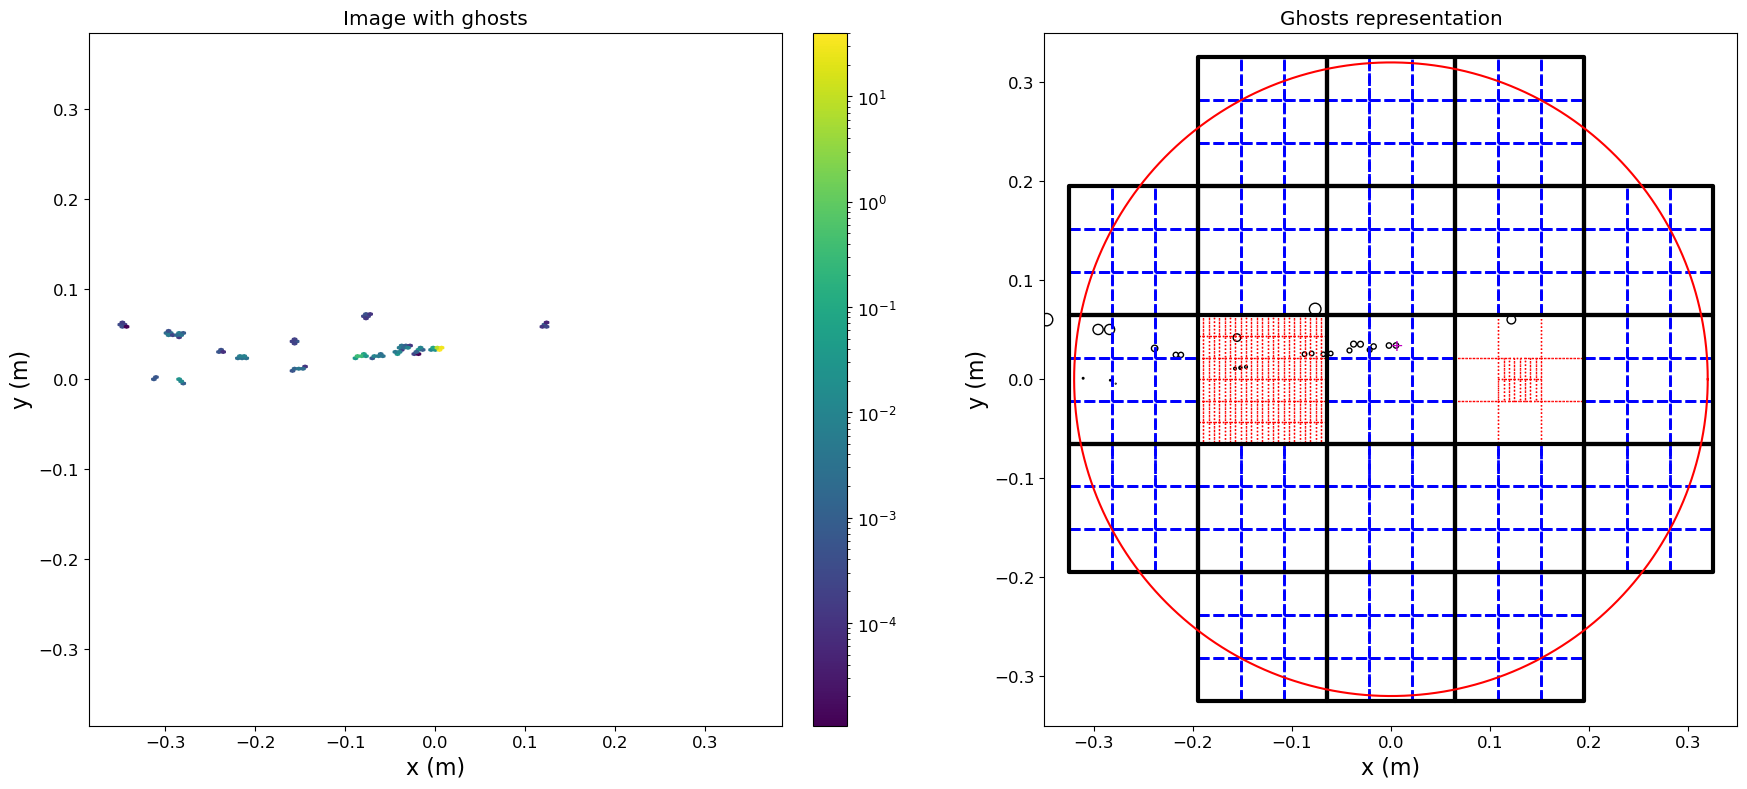

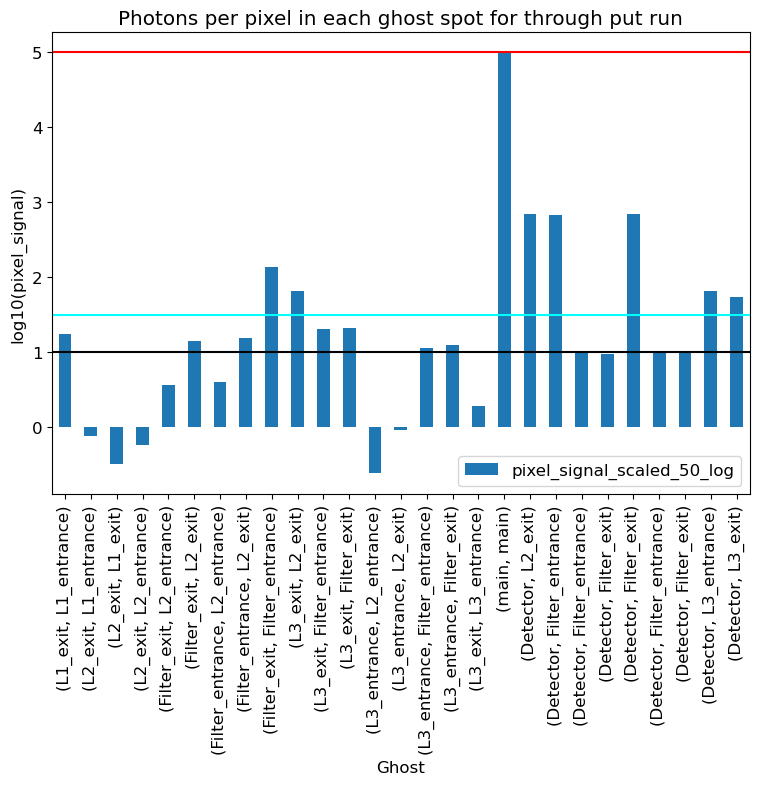

In [35]:
spots_r22_s11_3 = run_throughput_with_ghosts(r22_s11_beam_set[3])